# Football Transfer Market Data Analysis

This notebook is based on the 'Football Data from Transfermarkt Football (Soccer) data' on Kaggle, scraped from Transfermarkt website.

The notebook was created in March 2023, by David Coxon, with the purpose of learning to exploring sports data in a team sport. (I have previously worked with sports data in running and climbing).

If you find this notebook useful please upvote it, if you have any comments on the effectiveness of the visualisationd or how I could have achieved a better result please feel free to post comments. Also please check out the credits at the bottom for detail of other notebooks that I found helpful.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 4.3 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [ ]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
import datetime
from datetime import datetime, timedelta, date
import warnings
import os

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#settings
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 1200)
pd.set_option('display.width', 1200)
warnings.filterwarnings("ignore")
%matplotlib inline

#variables
colour=['maroon','r','g','darkgreen','c','teal','b','navy','indigo','m','deeppink','orange','sienna','yellow','khaki','olive','tan','black','grey','brown']

print("Packages installed")

Packages installed


# Get Data

In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving transfers.csv to transfers.csv
Saving players.csv to players.csv
Saving player_valuations.csv to player_valuations.csv
Saving games.csv to games.csv
Saving game_events.csv to game_events.csv
Saving competitions.csv to competitions.csv
Saving clubs.csv to clubs.csv
Saving club_games.csv to club_games.csv
Saving appearances.csv to appearances.csv


In [ ]:

# List of all DataFrames for storage
dataframes = []

# Process each uploaded file
for filename in uploaded.keys():
    # Define path to file
    filepath = filename

    # Handle 'players.csv' explicitly
    if filename == 'players.csv':
        players_df = pd.read_csv(filepath, sep=",", encoding="UTF-8")
        dataframes.append(players_df)
        print("players_df", players_df.shape)

    # Handle other CSV files
    else:
        file_name_without_extension = filename.split('.')[0]
        df_name = file_name_without_extension + "_df"

        # Load file into a DataFrame
        df = pd.read_csv(filepath, sep=",", encoding="UTF-8")

        # Dynamically assign variable names using globals()
        globals()[df_name] = df.copy()
        print(df_name, df.shape)

        # Add DataFrame to the list
        dataframes.append(df)

print('Data imported successfully!')


transfers_df (77847, 10)
players_df (32409, 23)
player_valuations_df (486249, 5)
games_df (70221, 23)
game_events_df (771505, 10)
competitions_df (44, 11)
clubs_df (439, 17)
club_games_df (140442, 11)
appearances_df (1621275, 13)
Data imported successfully!


In [ ]:
transfer_data = pd.read_csv('transfers.csv', sep=",", encoding="UTF-8")
transfer_df = pd.DataFrame(transfer_data)
player_data = pd.read_csv('players.csv', sep=",", encoding="UTF-8")
players_df = pd.DataFrame(player_data)
club_data = pd.read_csv('clubs.csv', sep=",", encoding="UTF-8")
clubs_df = pd.DataFrame(club_data)
appearances_data = pd.read_csv('appearances.csv', sep=",", encoding="UTF-8")
appearances_df = pd.DataFrame(appearances_data)
player_valuations_data = pd.read_csv('player_valuations.csv', sep=",", encoding="UTF-8")
player_valuations_df = pd.DataFrame(player_valuations_data)
clubs_data = pd.read_csv('clubs.csv', sep=",", encoding="UTF-8")
clubs_df = pd.DataFrame(clubs_data)
club_games_data = pd.read_csv('club_games.csv', sep=",", encoding="UTF-8")
club_games_df = pd.DataFrame(club_games_data)
competitions_data = pd.read_csv('competitions.csv', sep=",", encoding="UTF-8")
competitions_df = pd.DataFrame(competitions_data)


In [ ]:
transfers_df.head()

player_id transfer_date transfer_season  from_club_id  to_club_id  from_club_name     to_club_name  transfer_fee  market_value_in_eur      player_name
0     195778    2026-06-30           25/26            79          27   VfB Stuttgart    Bayern Munich           0.0           12000000.0  Alexander Nübel
1     569033    2026-06-30           25/26            39          27  1.FSV Mainz 05    Bayern Munich           0.0            4000000.0     Armindo Sieb
2     626913    2026-06-30           25/26           398         380           Lazio      Salernitana           0.0           10000000.0      Boulaye Dia
3    1047109    2026-06-30           25/26          2672         265  APO Levadiakos    Panathinaikos           0.0             100000.0  Georgios Katris
4     360791    2025-12-31           25/26          6418        1030     Panetolikos  Argentinos Jrs.           0.0            1200000.0     Lucas Chaves

# Process Data

In [ ]:
try:
    players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
except NameError:
    print("players_df is not defined. Make sure you have loaded the 'players.csv' file.")

In [ ]:
# Calculate the age of each player
try:
    players_df['date_of_birth'] = pd.to_datetime(players_df['date_of_birth'])
except NameError:
    print("players_df is not defined. Make sure you have loaded the 'players.csv' file.")
# drop players with no date of birth
players_df = players_df[players_df['date_of_birth'].isnull() == False]
now = datetime.now()
players_df['age'] = (now - players_df['date_of_birth']).apply(lambda x: x.days) / 365.25
players_df['age'] = players_df['age'].round().astype(int)

# Calculate the contract remaining of each player
players_df['contract_expiration_date'] = pd.to_datetime(players_df['contract_expiration_date'])
# drop players with no date of birth
players_df = players_df[players_df['contract_expiration_date'].isnull() == False]
now = datetime.now()
players_df['term_days_remaining'] = (players_df['contract_expiration_date']- now).apply(lambda x: x.days)

# add year to player valuations
# Check if 'date' column exists before renaming
if 'date' in player_valuations_df.columns:
    player_valuations_df = player_valuations_df.rename(columns={'date': 'datetime'})  # Rename 'date' to 'datetime' if it exists
else:
    print("Warning: 'date' column not found in player_valuations_df")

# add year to player valuations
player_valuations_df['datetime']=pd.to_datetime(player_valuations_df['datetime'], format="%Y-%m-%d")
player_valuations_df['year']=player_valuations_df['datetime'].dt.year

# add year to player appearances
appearances_df['datetime']=pd.to_datetime(appearances_df['date'], format="%Y-%m-%d")
appearances_df['year']=appearances_df['datetime'].dt.year

#add position to player valuations
position_df=players_df.copy()
position_df=position_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'market_value_in_eur', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
player_valuations_df=player_valuations_df.merge(position_df, left_on='player_id', right_on='player_id')

#add position to appearances
value_df=players_df.copy()
value_df=value_df.drop(['name', 'current_club_id', 'current_club_name', 'country_of_citizenship', 'country_of_birth', 'city_of_birth', 'date_of_birth', 'foot', 'height_in_cm', 'sub_position', 'highest_market_value_in_eur', 'agent_name', 'contract_expiration_date', 'current_club_domestic_competition_id', 'first_name', 'last_name', 'player_code', 'image_url', 'last_season', 'url', 'age'], axis=1)
appearances_df1=value_df.merge(appearances_df, left_on='player_id', right_on='player_id')

print("Data processing complete")

Data processing complete


## Observations on clubs

The scatters plot show squad sizes range from 15 to 40 (the majority being in the 24 to 32 range), with over total valve of up to 600 (the majority being under 150,

The chart appears to indicate that 4 of the clubs with the highest squad values have no national team players, and that 3 of the top 6 clubs have relatively small squads 20-25 players, but generally the teams with biggest squards have higher total values have more players than play for national teams and more international players.

There are large national differences, with many countries having a couple of dominant clubs with high values, larger squads and more players that play for national teams.
It's likely that knowing which team a player, currently plays for will be a good indicator for player transfer value.

# Player Valuation Data Visualization

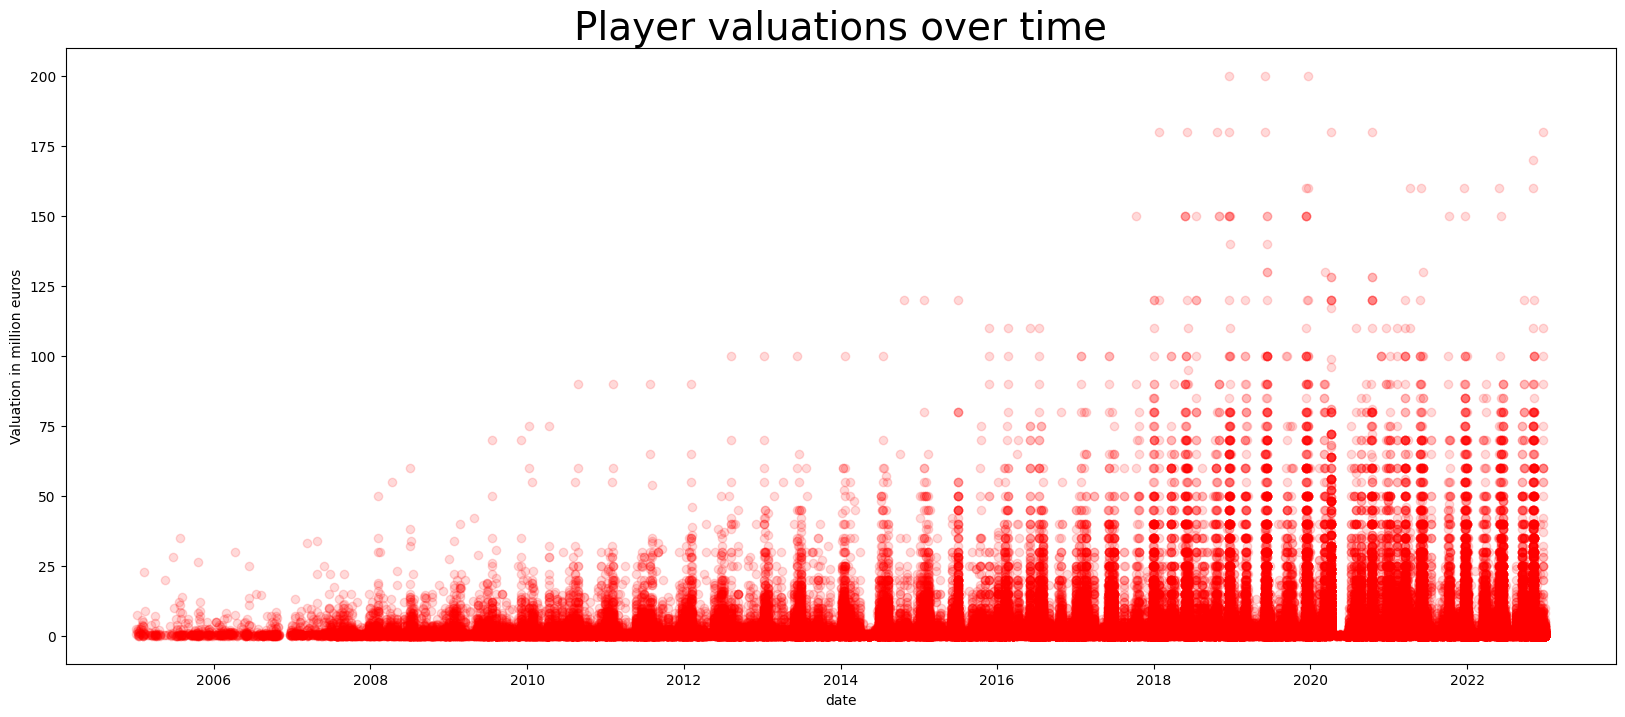

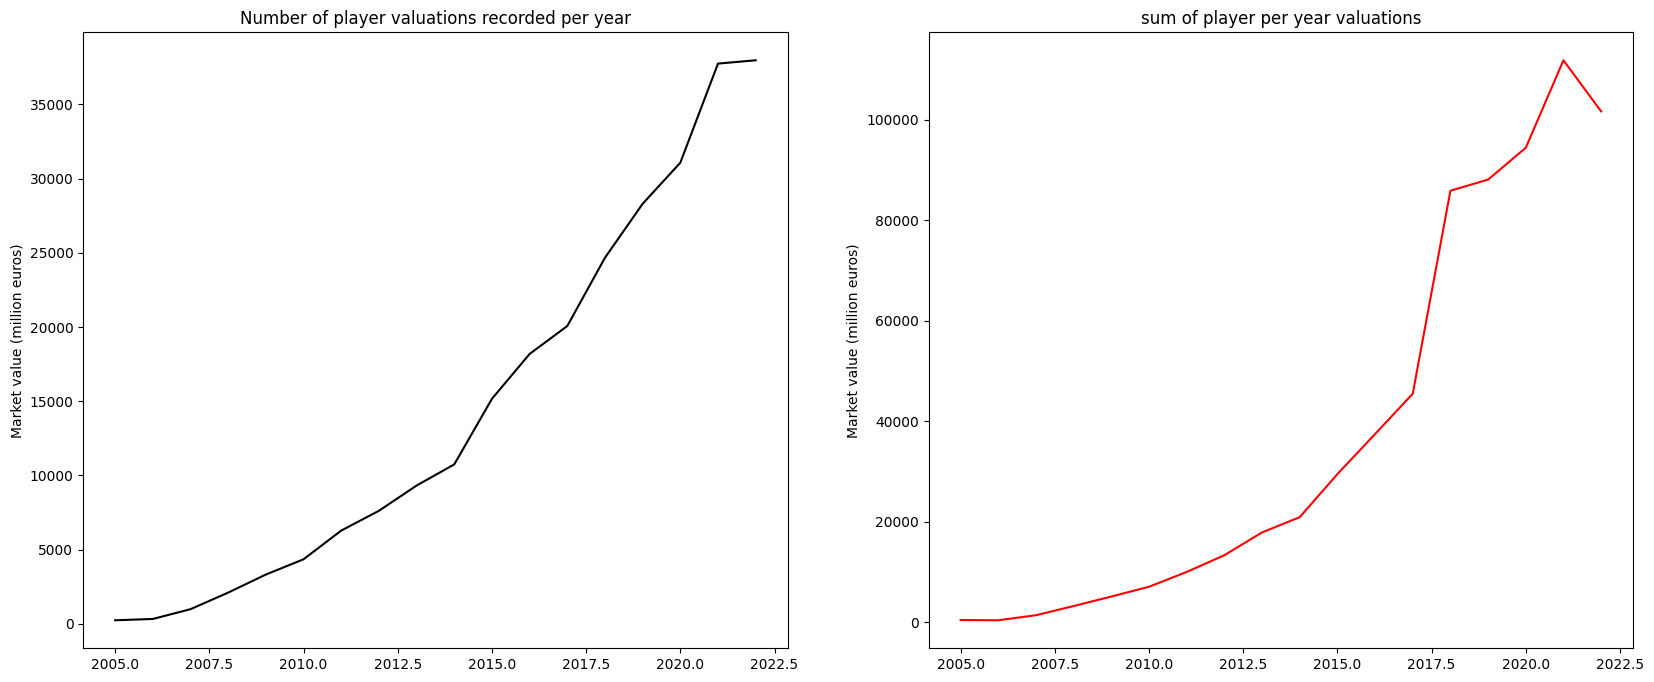

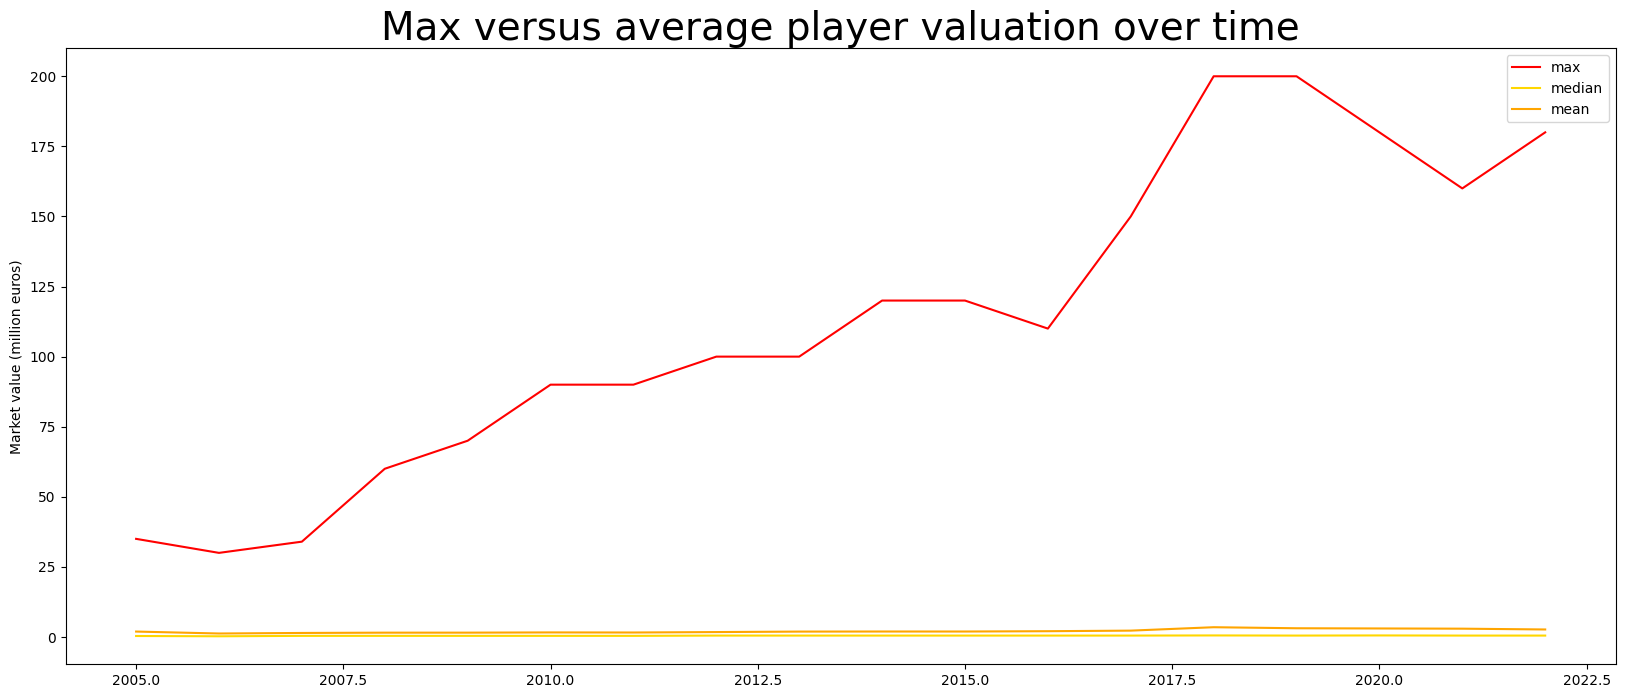

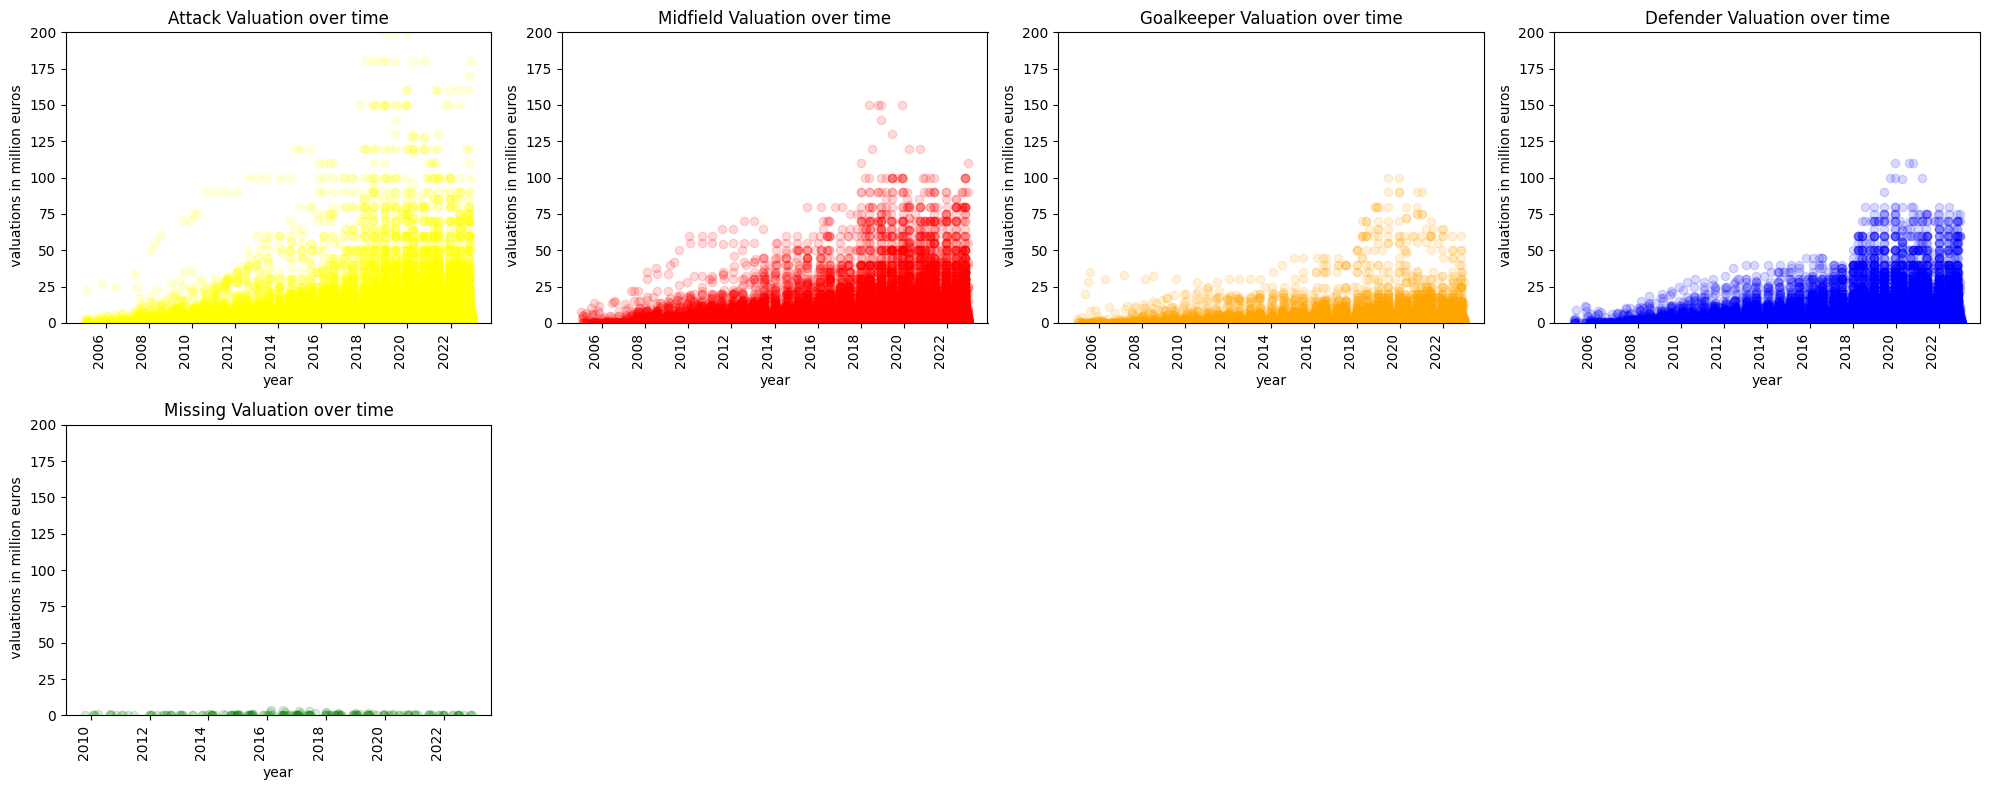

In [ ]:
#filter range
player_valuations_df = player_valuations_df[(player_valuations_df.year > 2004 ) & (player_valuations_df.year < 2023 )]
high_value_player_valuations_df = player_valuations_df[(player_valuations_df.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

# Lookat data
#print(player_valuations_df.columns)

# Visualize of valuation data over time
plt.figure(figsize=(20,8))
plt.scatter(player_valuations_df['datetime'],y=player_valuations_df['market_value_in_eur']/1000000, c='red',alpha=0.15)
plt.xlabel('date');plt.ylabel('Valuation in million euros')
plt.title('Player valuations over time',fontsize=28)
plt.show()

# Visualize of valuation data over time
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
yeargroups1 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).count() \
    .sort_values(by='year', ascending=True)
yeargroups2 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).sum() \
    .sort_values(by='year', ascending=True)
yeargroups3 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).max() \
    .sort_values(by='year', ascending=True)
yeargroups4 = player_valuations_df.loc[:,['market_value_in_eur', 'year']] .groupby(['year']).min() \
    .sort_values(by='year', ascending=True)
yeargroups5 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).median() \
    .sort_values(by='year', ascending=True)
yeargroups6 = player_valuations_df.loc[:,['market_value_in_eur', 'year']].groupby(['year']).mean() \
    .sort_values(by='year', ascending=True)

plt.subplot(1, 2, 1)
plt.title('Number of player valuations recorded per year')
plt.plot(yeargroups1.index,yeargroups1,color='black')
plt.ylabel('Market value (million euros)')
plt.subplot(1, 2, 2)
plt.title('sum of player per year valuations')
plt.plot(yeargroups2.index,yeargroups2/1000000,color='red')
plt.ylabel('Market value (million euros)')
plt.show()
plt.figure(figsize=(20,8))
plt.title('Max versus average player valuation over time',fontsize=28)
plt.plot(yeargroups3.index,yeargroups3/1000000,color='r',label='max')
plt.plot(yeargroups5.index,yeargroups5/1000000,color='Gold',label='median')
plt.plot(yeargroups6.index,yeargroups6/1000000,color='Orange',label='mean')
plt.ylabel('Market value (million euros)')
plt.legend()
plt.show()

# valuation by position
plt.figure(figsize=(20,8))
n=1;colour=['yellow','r','orange','b','g','purple','pink','cyan','magenta','brown','gray','black','lime','olive'] # extend colour list
num_positions = len(positions) # get total number of positions
num_cols = 4  # Number of columns in the subplot grid
num_rows = (num_positions + num_cols - 1) // num_cols  # Calculate number of rows needed

for i, position in enumerate(positions):
    plt.subplot(num_rows, num_cols, i + 1)  # Create subplot, index starts from 1
    player_valuations_df1 = player_valuations_df[(player_valuations_df.position==position)]
    plt.scatter(player_valuations_df1['datetime'],y=player_valuations_df1['market_value_in_eur']/1000000, c=colour[i],alpha=0.15) #use i to index colour list
    plt.xlabel('year')
    plt.ylabel(' valuations in million euros')
    plt.title(position+' Valuation over time') #add space to title for better readability
    plt.ylim(0,200)
    plt.xticks(rotation=90, ha='right')
plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

## Observations on market value timeline data

The scatter plot of player valuations over the period 2006 to 2022 shows that the value of players has generally risen over time. The plot shows that the vast majority of players are at the lower end of the scale below the 50 million euros mark.

Separating player values in attack,midfield,defence and goal keeper positions shows attacking positions generally achieve the highest values while goal keepers command lower values.

There appears to be a shift around 2018 in where values at the higher end of the scale in most positions rose dramatically, this appears to have peaked and come down a little to 2022 rates.

# Player Data Visualization

Explorator data visualizations relating to players who's last season played was 2022 or 2023 with a market value of greater that 15 million euros.

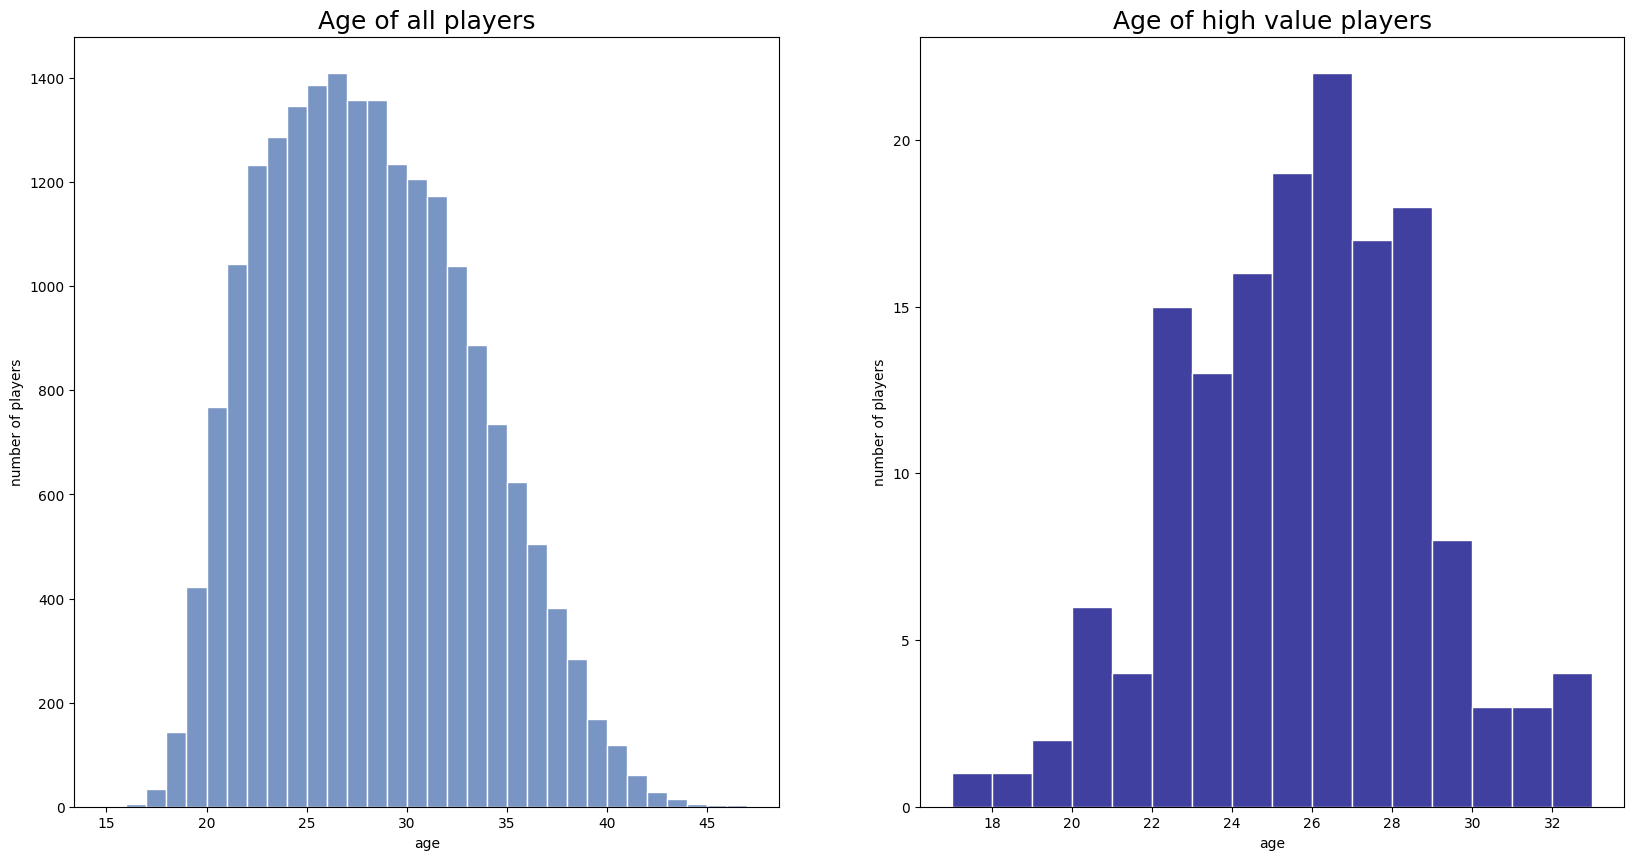

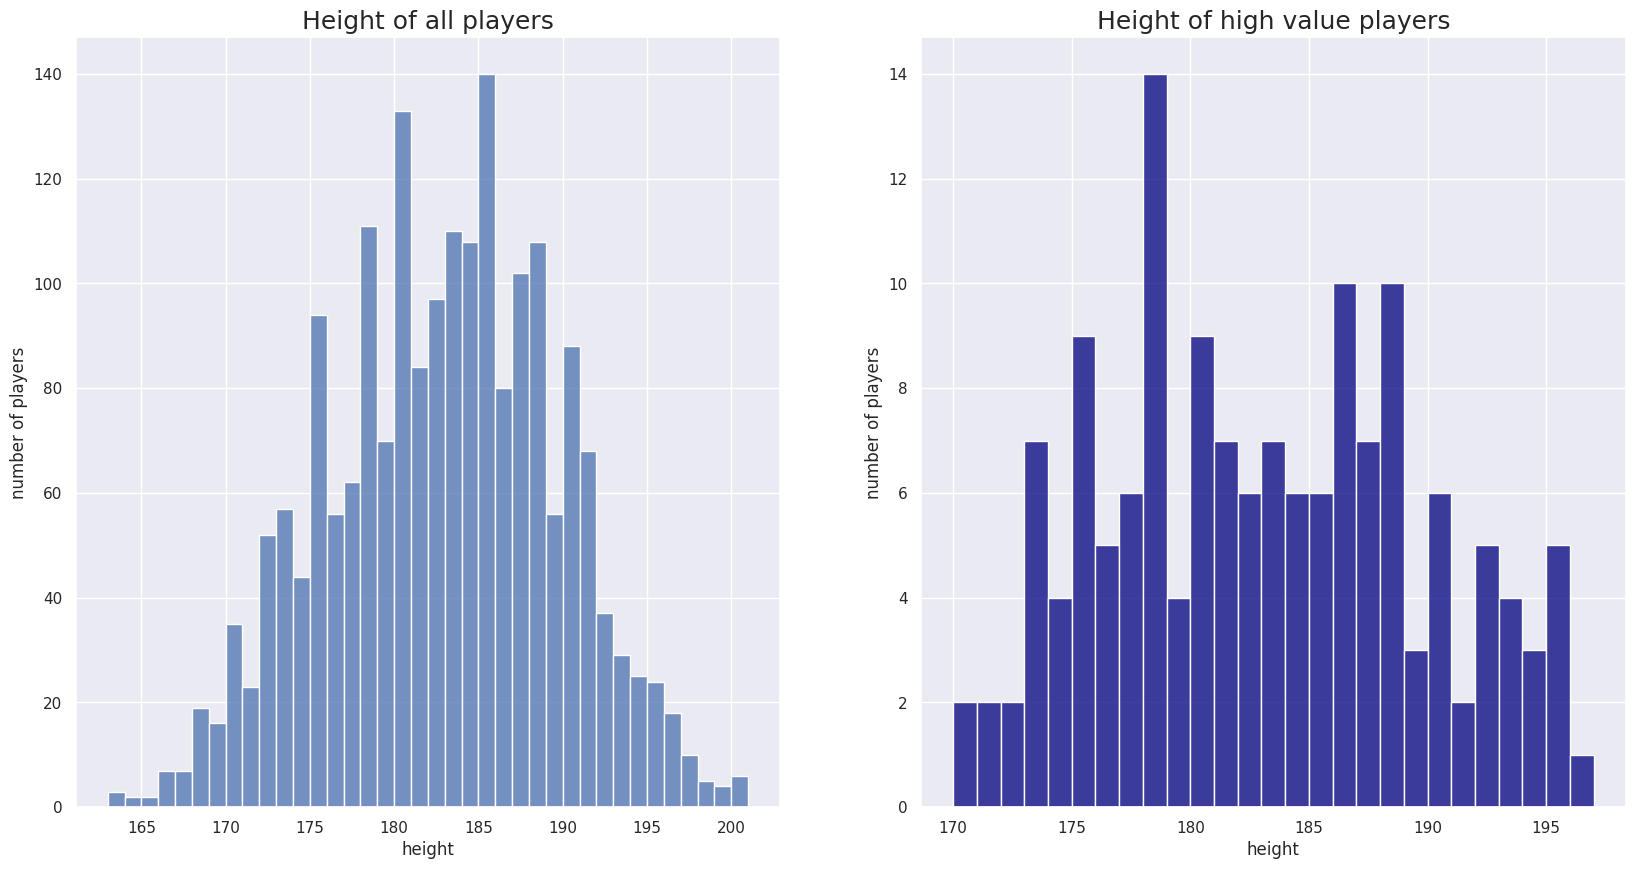

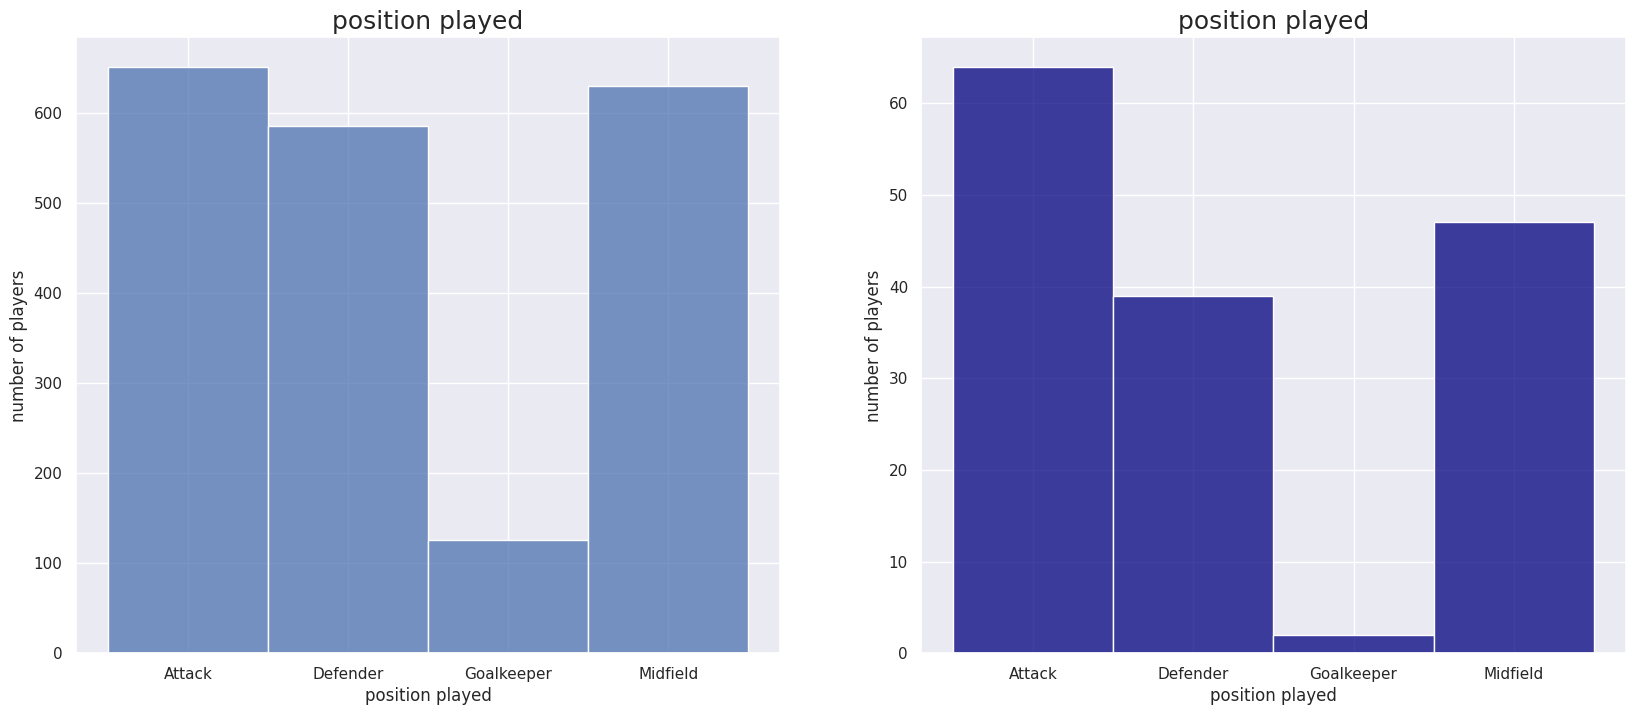

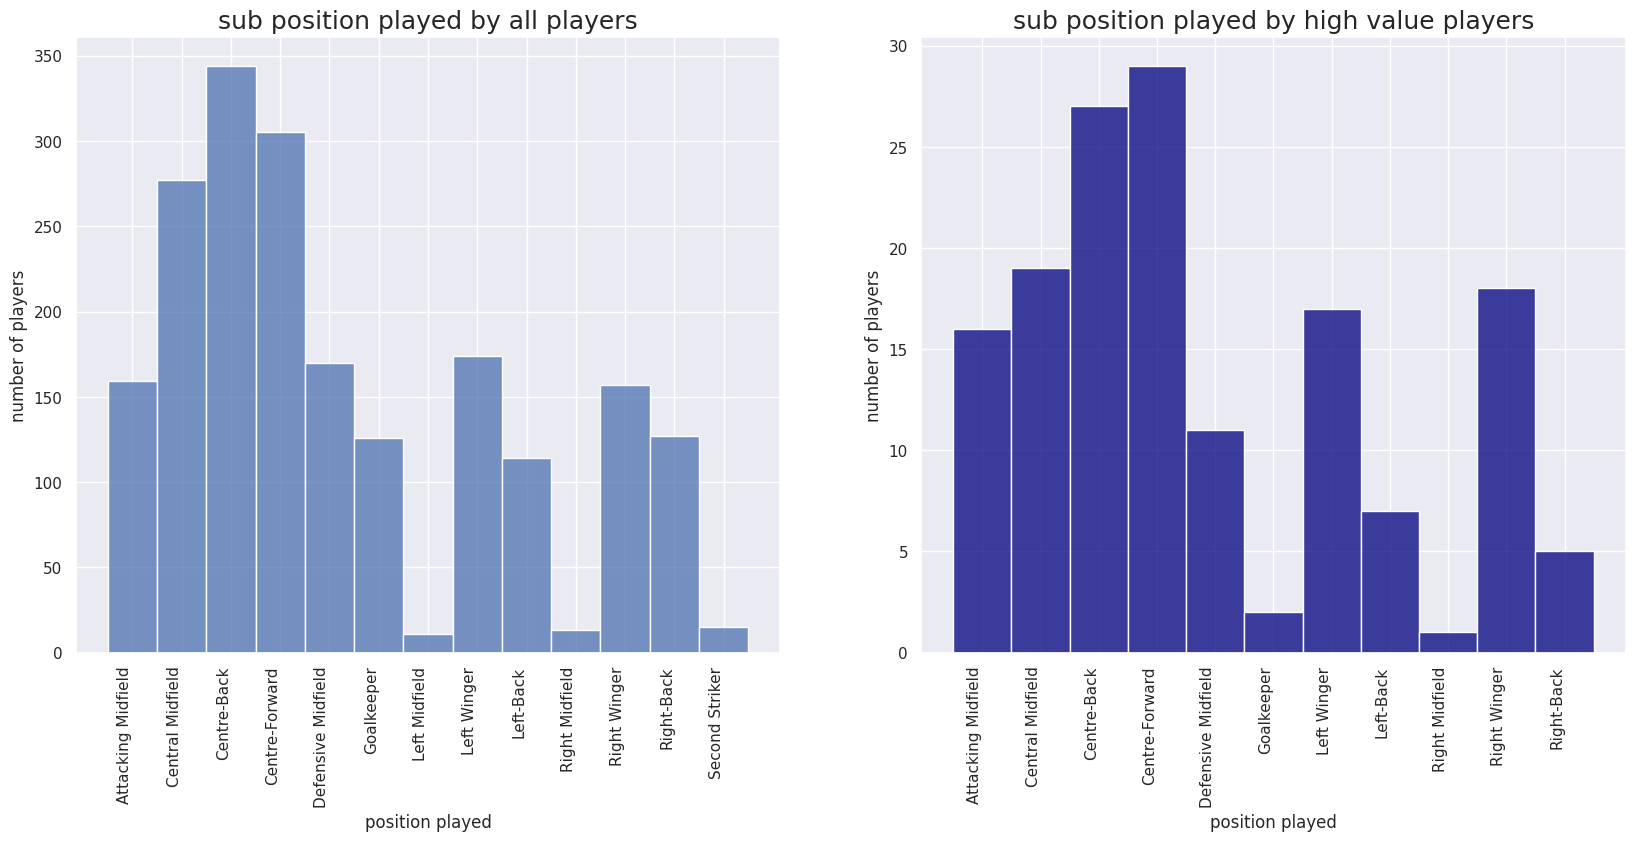

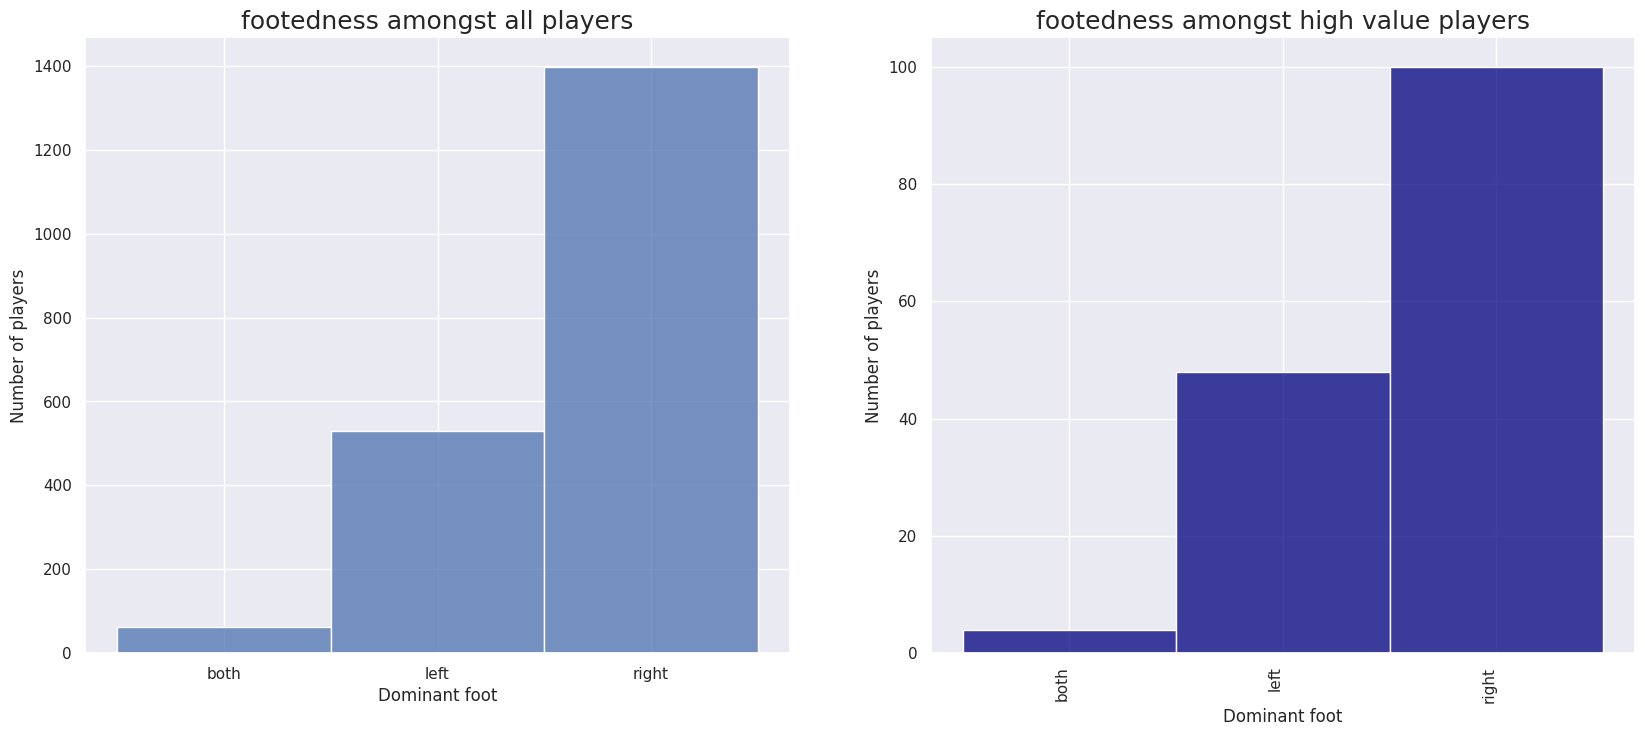

In [ ]:
#overview of player dataset
#remove players with no Market Value
players_df1 = players_df[players_df.highest_market_value_in_eur.isnull() == False]
#order by Market Value
players_df1 = players_df1.sort_values("highest_market_value_in_eur", ascending = False)
#filter by season and value
players_df1 = players_df[players_df['last_season'] >= 2021]
players_df1 = players_df1[players_df1['highest_market_value_in_eur'] >= 10000000]
high_value_players_df = players_df1[(players_df1.market_value_in_eur > 40000000 )]
positions=players_df.position.unique()

# Show player age distribution
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='age',data=players_df, binwidth=1,color='b')
plt.title("Age of all players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='age',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Age of high value players",fontsize=18)
plt.xlabel('age'); plt.ylabel('number of players')

# Show player height distribution
players_df3 = players_df1[players_df1.height_in_cm.isnull() == False]
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.set(rc={'figure.figsize':(20,10)})
sns.histplot(x='height_in_cm',data=players_df3, binwidth=1,color='b')
plt.title("Height of all players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='height_in_cm',data=high_value_players_df, binwidth=1,color='navy')
plt.title("Height of high value players",fontsize=18)
plt.xlabel('height'); plt.ylabel('number of players')

# Show position data
players_df1 = players_df1.sort_values("position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
plt.title("position played",fontsize=18);plt.grid(True)
sns.histplot(x='position',data=players_df1, binwidth=1,color='b')
plt.xlabel('position played'); plt.ylabel('number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("position played",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')

# Show subposition data
players_df1 = players_df1.sort_values("sub_position", ascending = True)
high_value_players_df1 = high_value_players_df.sort_values("sub_position", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='sub_position',data=players_df1, binwidth=1,color='b')
plt.title("sub position played by all players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');
plt.subplot(1, 2, 2)
sns.histplot(x='sub_position',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("sub position played by high value players",fontsize=18);plt.grid(True)
plt.xlabel('position played'); plt.ylabel('number of players')
plt.xticks(rotation=90, ha='right');

# Show  footedness data
players_df1 = players_df1.sort_values("foot", ascending = True)
high_value_players_df1 = high_value_players_df1.sort_values("foot", ascending = True)
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
plt.subplot(1, 2, 1)
sns.histplot(x='foot',data=players_df1, binwidth=1,color='b')
plt.title("footedness amongst all players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.subplot(1, 2, 2)
sns.histplot(x='foot',data=high_value_players_df1, binwidth=1,color='navy')
plt.title("footedness amongst high value players",fontsize=18);plt.grid(True)
plt.xlabel('Dominant foot'); plt.ylabel('Number of players')
plt.xticks(rotation=90, ha='right');

## Observations on player data visualizations

Generally the distibutions of age is a skewed normal distribution and height is a normal distribution.
Distibutions amongst high value players appear to be reflective of values within the entire dataset.

# Appearance Visualizations

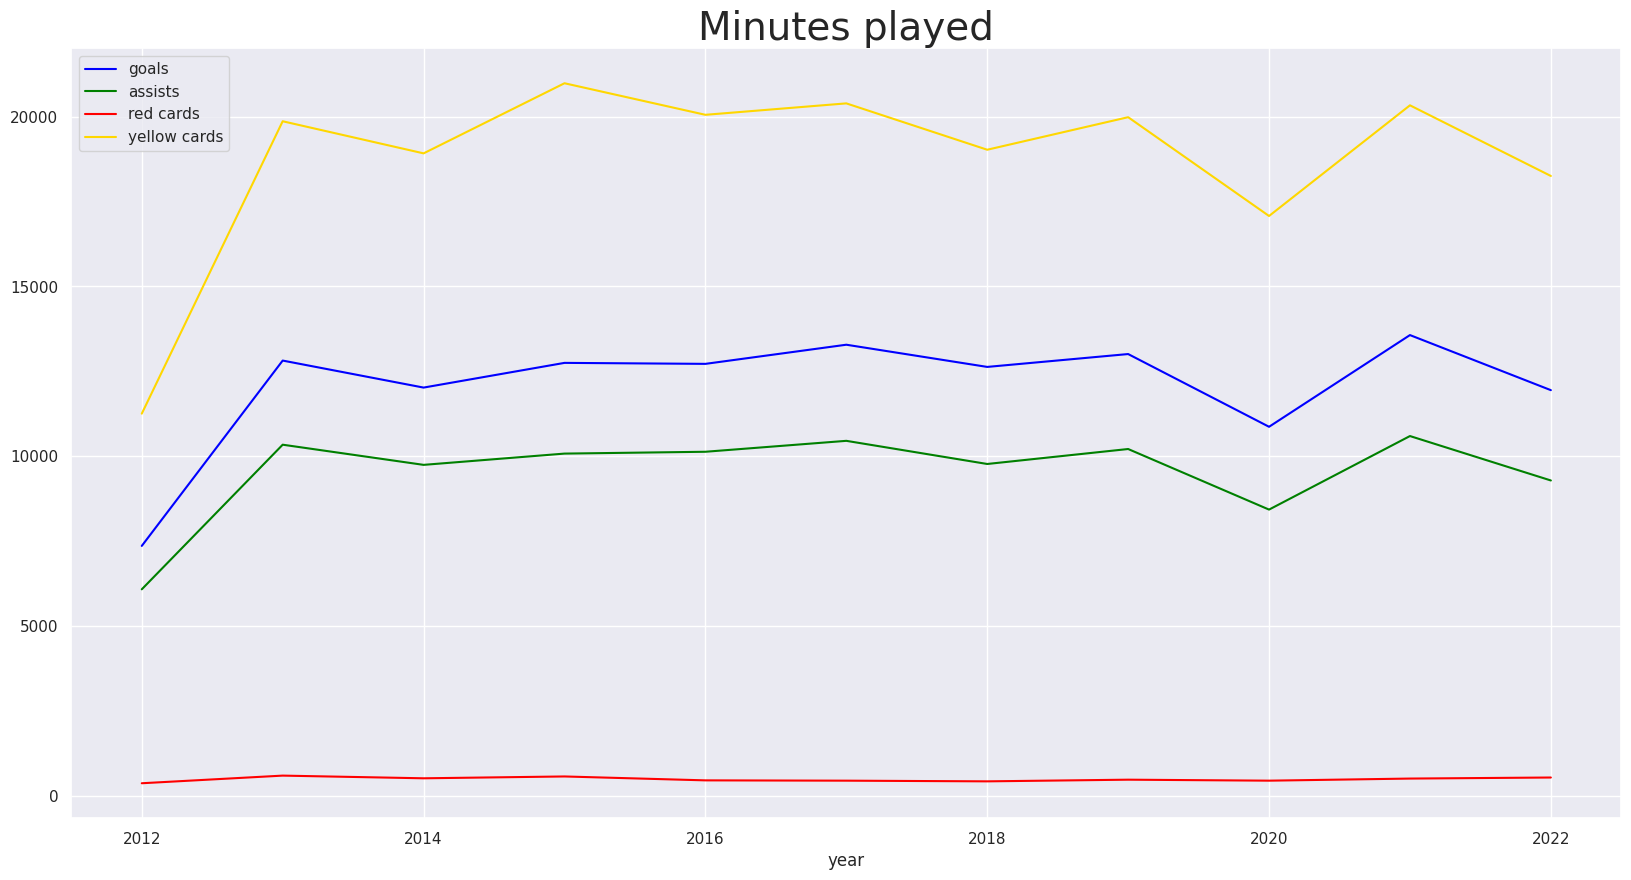

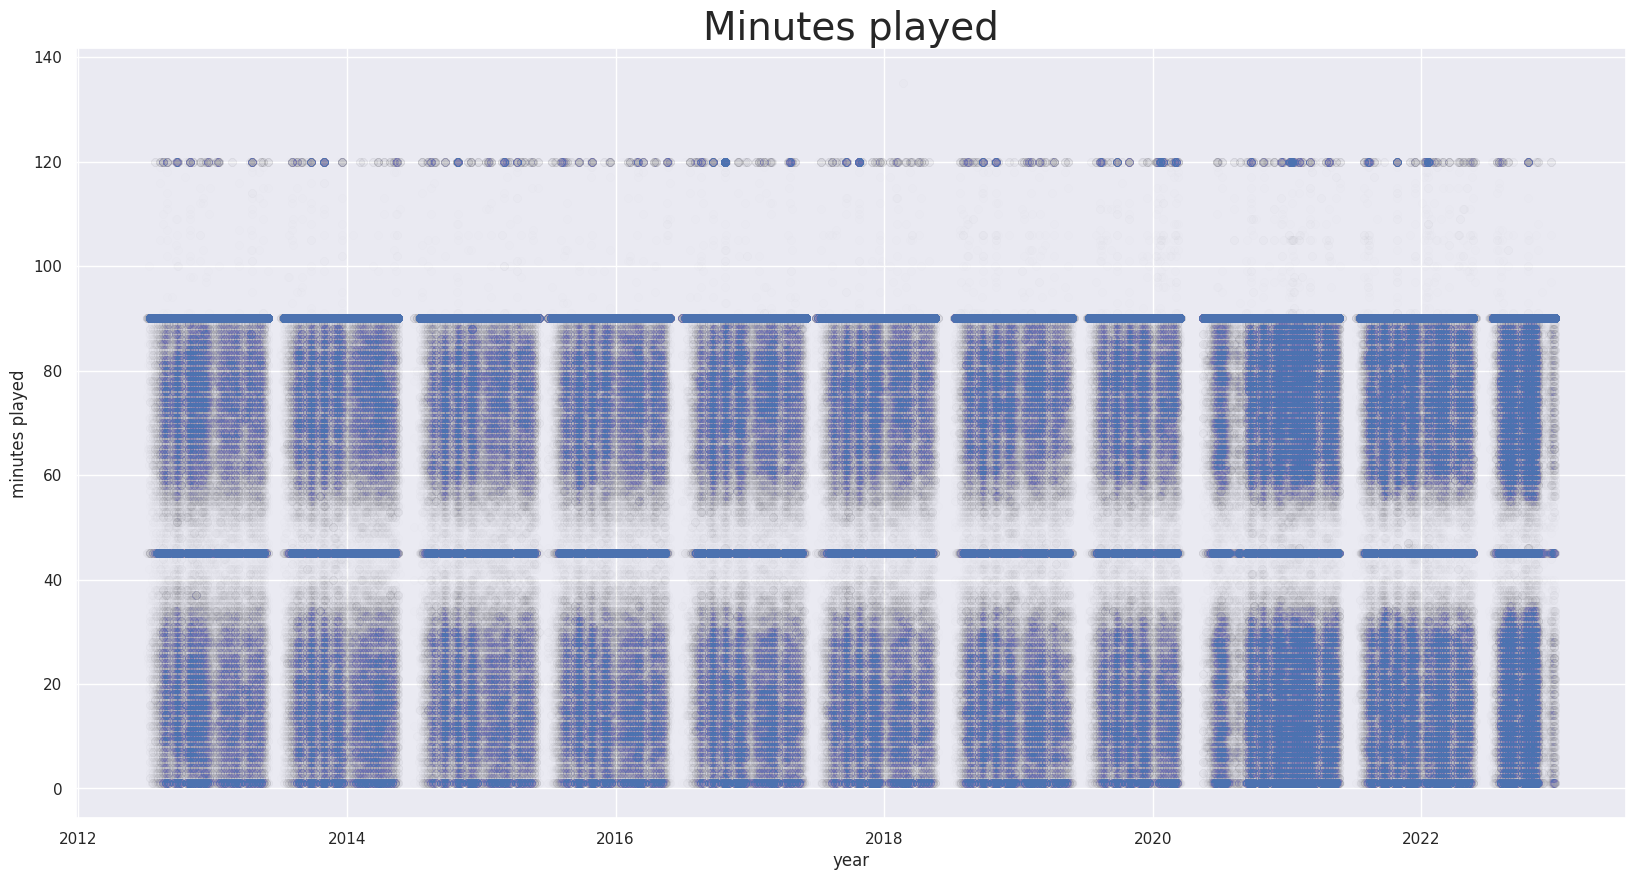

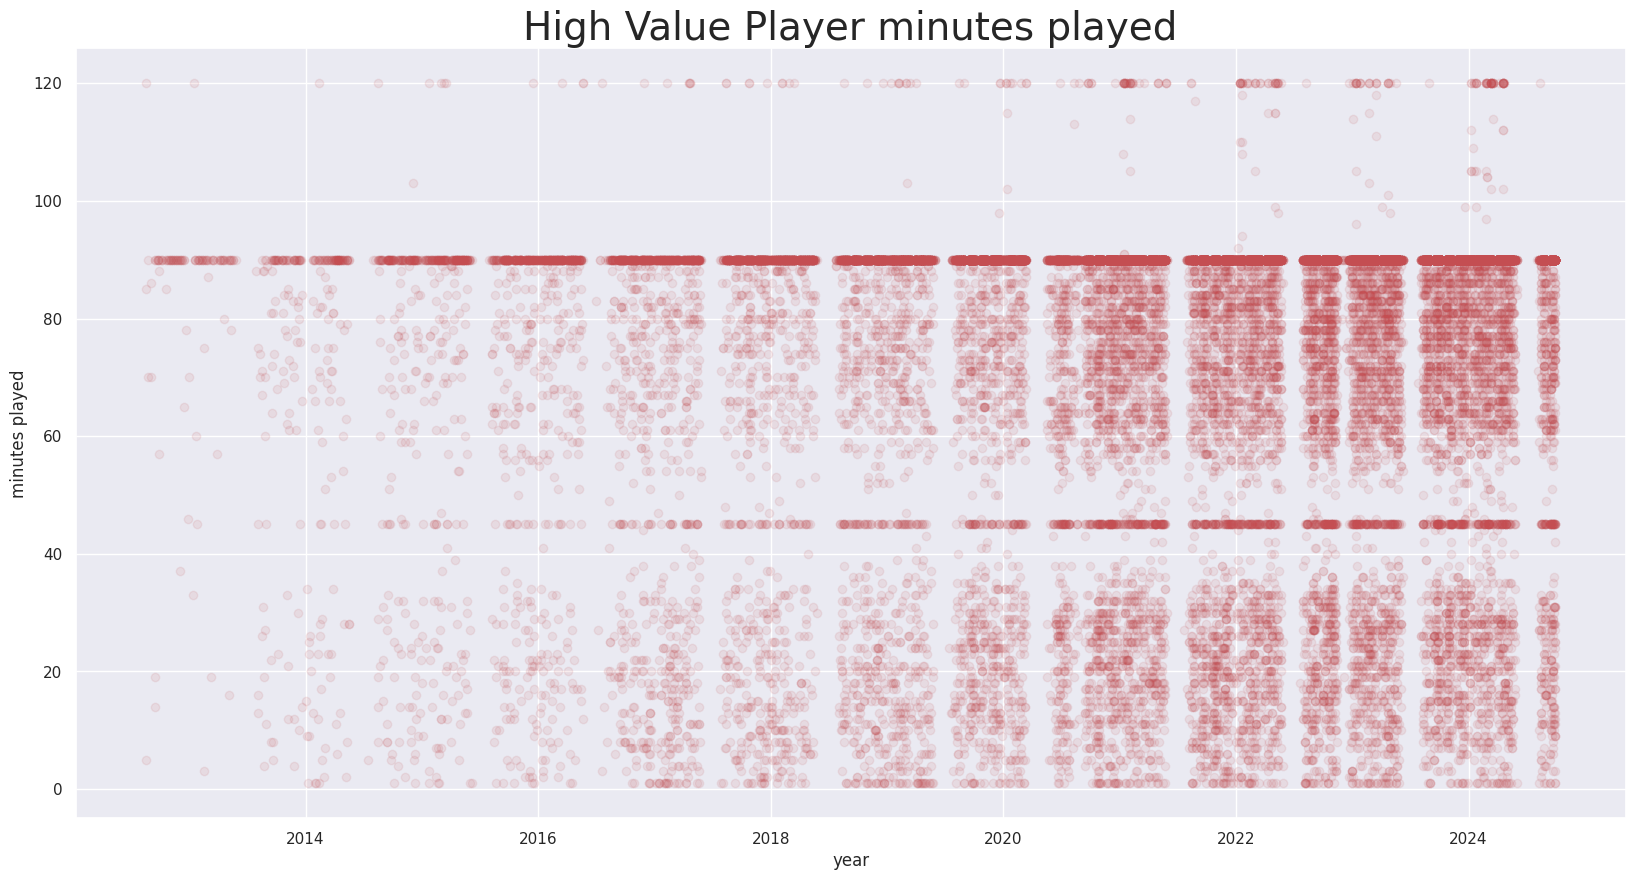

In [ ]:
#print(appearances_df.columns); print(appearances_df.shape)

#filter range
appearances_df = appearances_df[(appearances_df.year > 2004 ) & (appearances_df.year < 2023 )]
high_value_appearances_df = appearances_df1[(appearances_df1.market_value_in_eur > 40000000 )]

#Goals, assists and cards
yeargroups1 = appearances_df.loc[:,['goals', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups2 = appearances_df.loc[:,['assists', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups3 = appearances_df.loc[:,['red_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
yeargroups4 = appearances_df.loc[:,['yellow_cards', 'year']].groupby(['year']).sum().sort_values(by='year', ascending=True)
plt.plot(yeargroups1.index,yeargroups1,color='blue',label='goals')
plt.plot(yeargroups2.index,yeargroups2,color='green',label='assists')
plt.plot(yeargroups3.index,yeargroups3,color='red',label='red cards')
plt.plot(yeargroups4.index,yeargroups4,color='gold',label='yellow cards')
plt.xlabel("year")
plt.title('Minutes played',fontsize=28);plt.legend()
plt.show()

# Explore minutes played
plt.scatter(appearances_df['datetime'],y=appearances_df['minutes_played'],alpha=0.0025,color='b')
plt.xlabel("year");plt.ylabel('minutes played')
plt.title('Minutes played',fontsize=28)
plt.show()

# Explore minutes played
plt.scatter(high_value_appearances_df['datetime'],y=high_value_appearances_df['minutes_played'],alpha=0.1,color='r')
plt.xlabel("year");plt.ylabel('minutes played')
plt.title('High Value Player minutes played',fontsize=28)
plt.show()

# Game Visualizations

# Data visualisation of market value by age

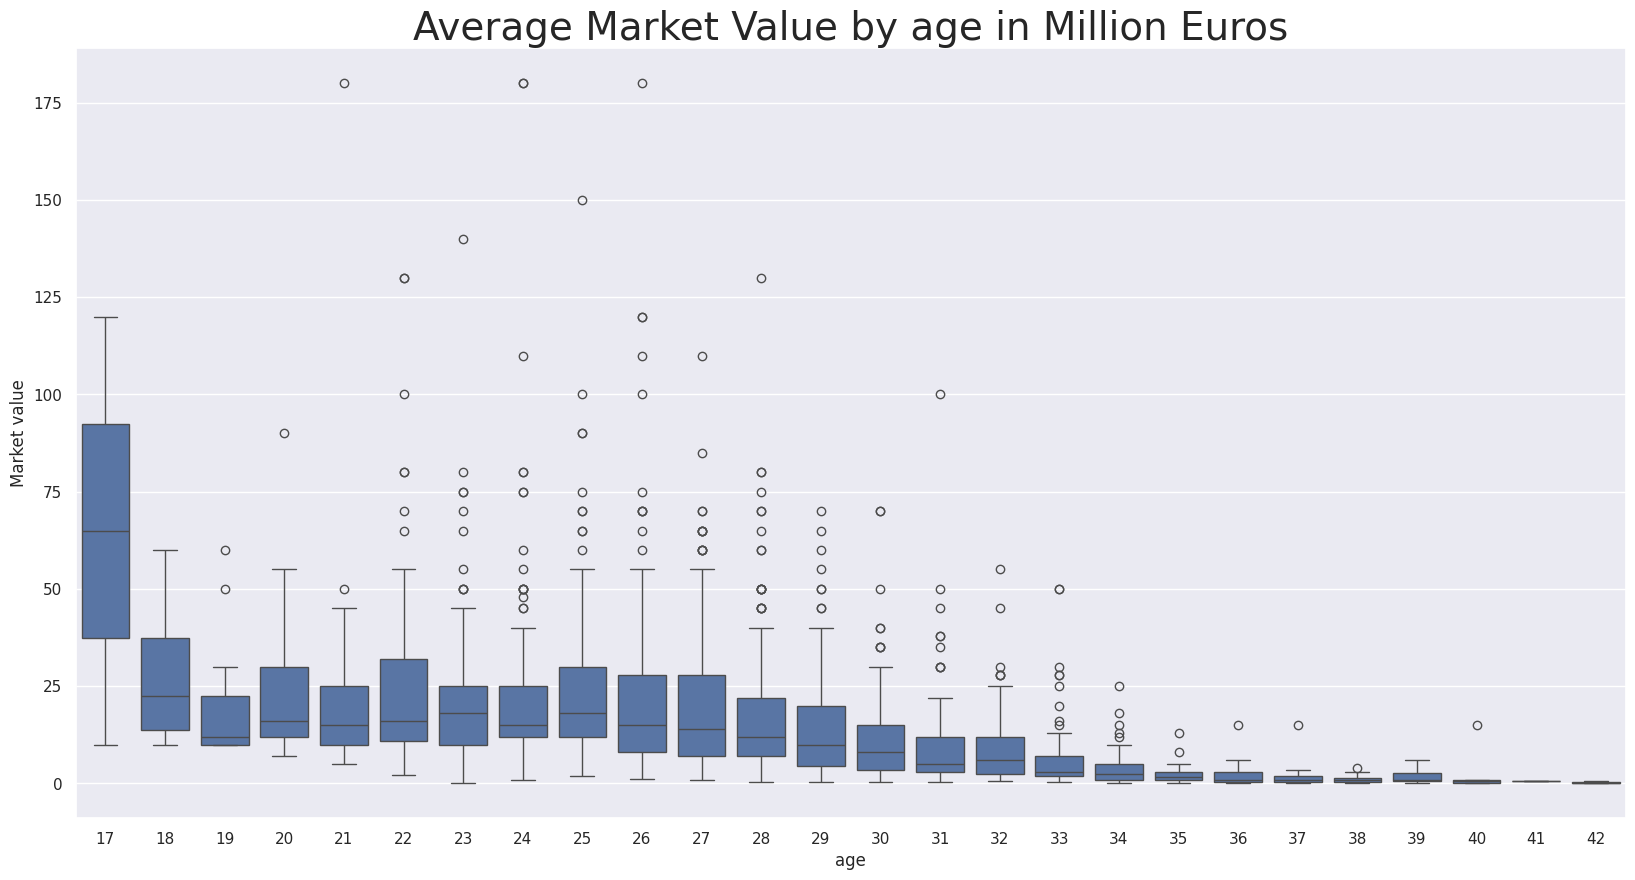

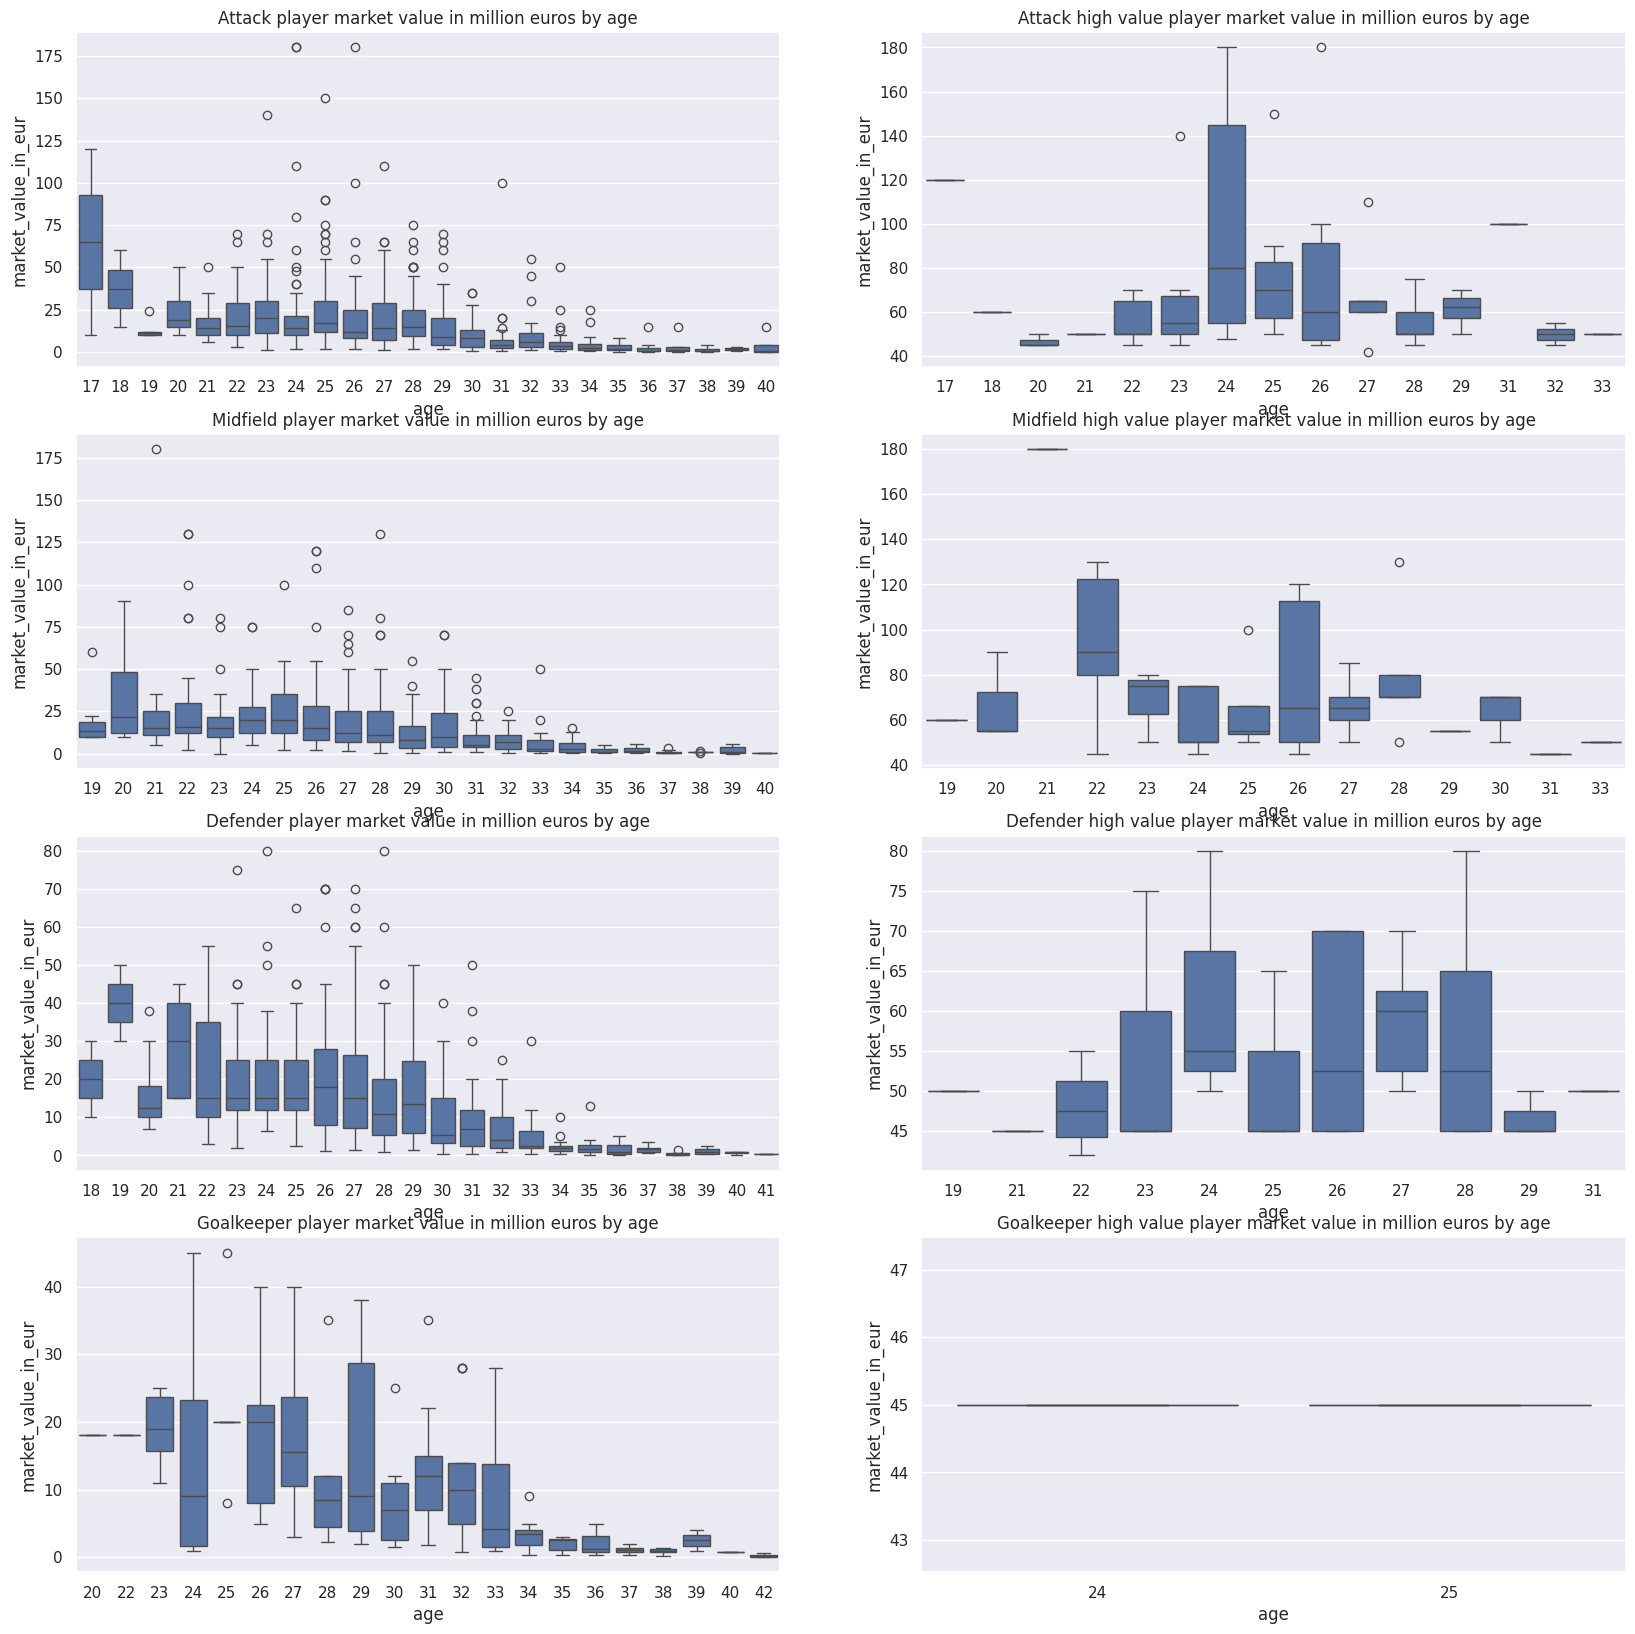

In [ ]:
#market value by age
agegroups = players_df1.loc[:,['market_value_in_eur', 'age']] \
    .groupby(['age']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Market value')
sns.boxplot(x=players_df1["age"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Average Market Value by age in Million Euros',fontsize=28)
plt.show()
# show Market Value for each position by age
positions=players_df1.position.unique()
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(421);ax2 = f.add_subplot(422);ax3 = f.add_subplot(423);ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425);ax6 = f.add_subplot(426);ax7 = f.add_subplot(427);ax8 = f.add_subplot(428)
n=1
for position in positions:
    plt.subplot(4,2,n); n=n+1
    players_df2 = players_df1[players_df1['position'] == position]
    agegroups = players_df2.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=players_df2["age"], y=(players_df2['market_value_in_eur'])/1000000)
    title=str(position+' player market value in million euros by age');plt.title(title)
    plt.subplot(4,2,n); n=n+1
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    agegroups = high_value_players_df.loc[:,['market_value_in_eur', 'age']].groupby(['age']).median().sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=high_value_players_df2["age"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    title=str(position+' high value player market value in million euros by age'); plt.title(title)
plt.show()

## Observations on age

The age distribution of players is a skewed normal distribution starting at 17 years of age and going up 50 with an average age of 29. Players with a market value to over 400,000 euros form a normal distribution ranging from 19 to 32 years of age, with a significant number at age 25.

# Data visualisation of market value by height

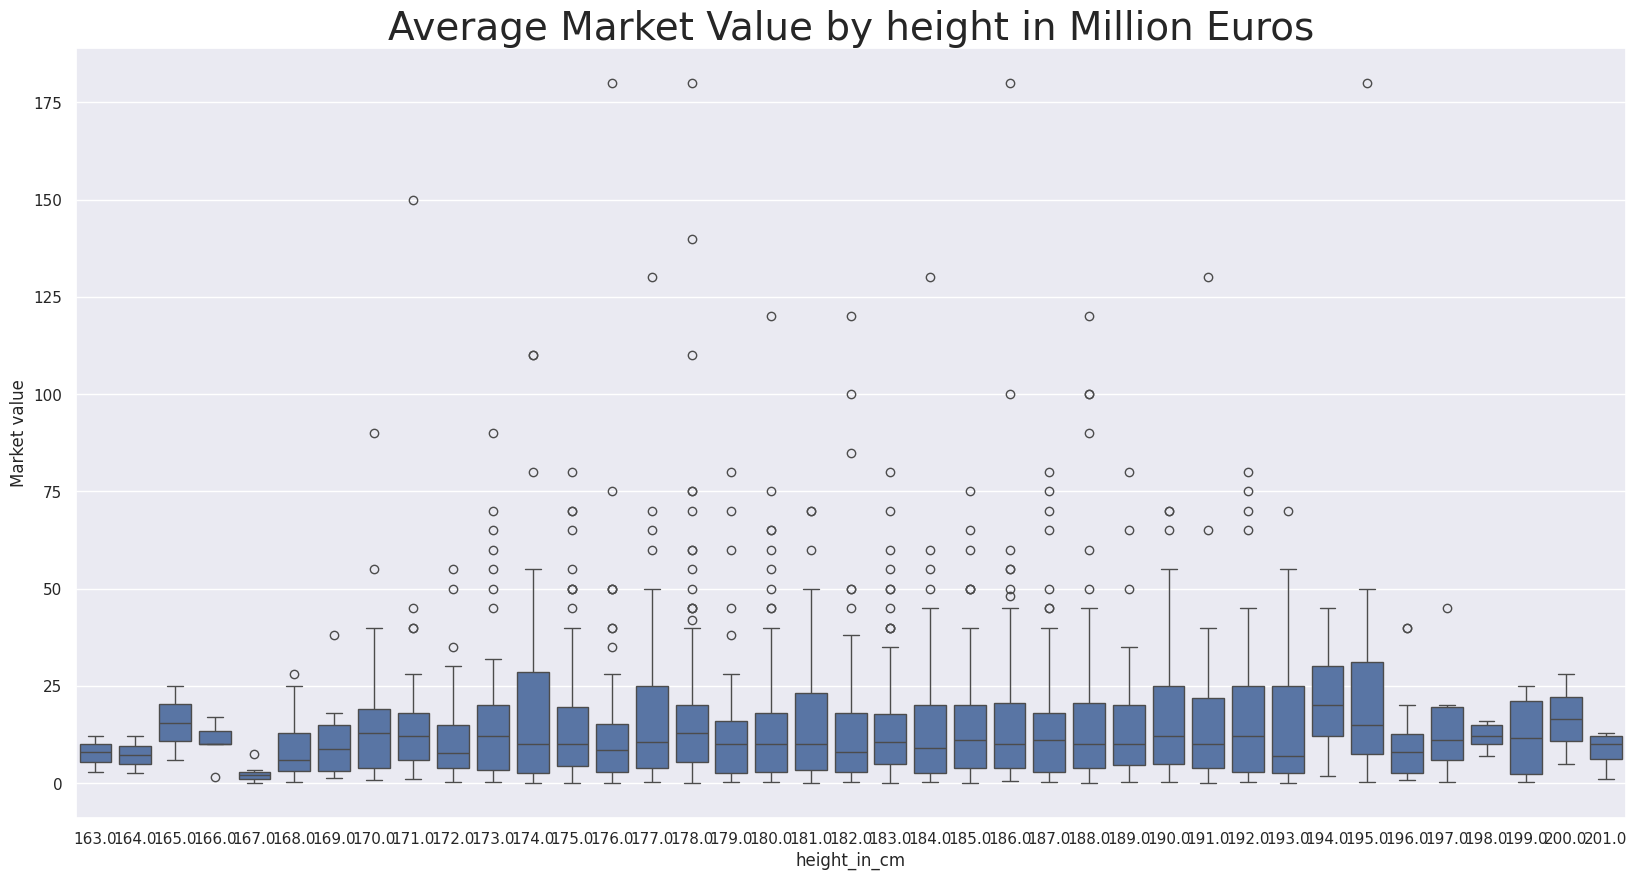

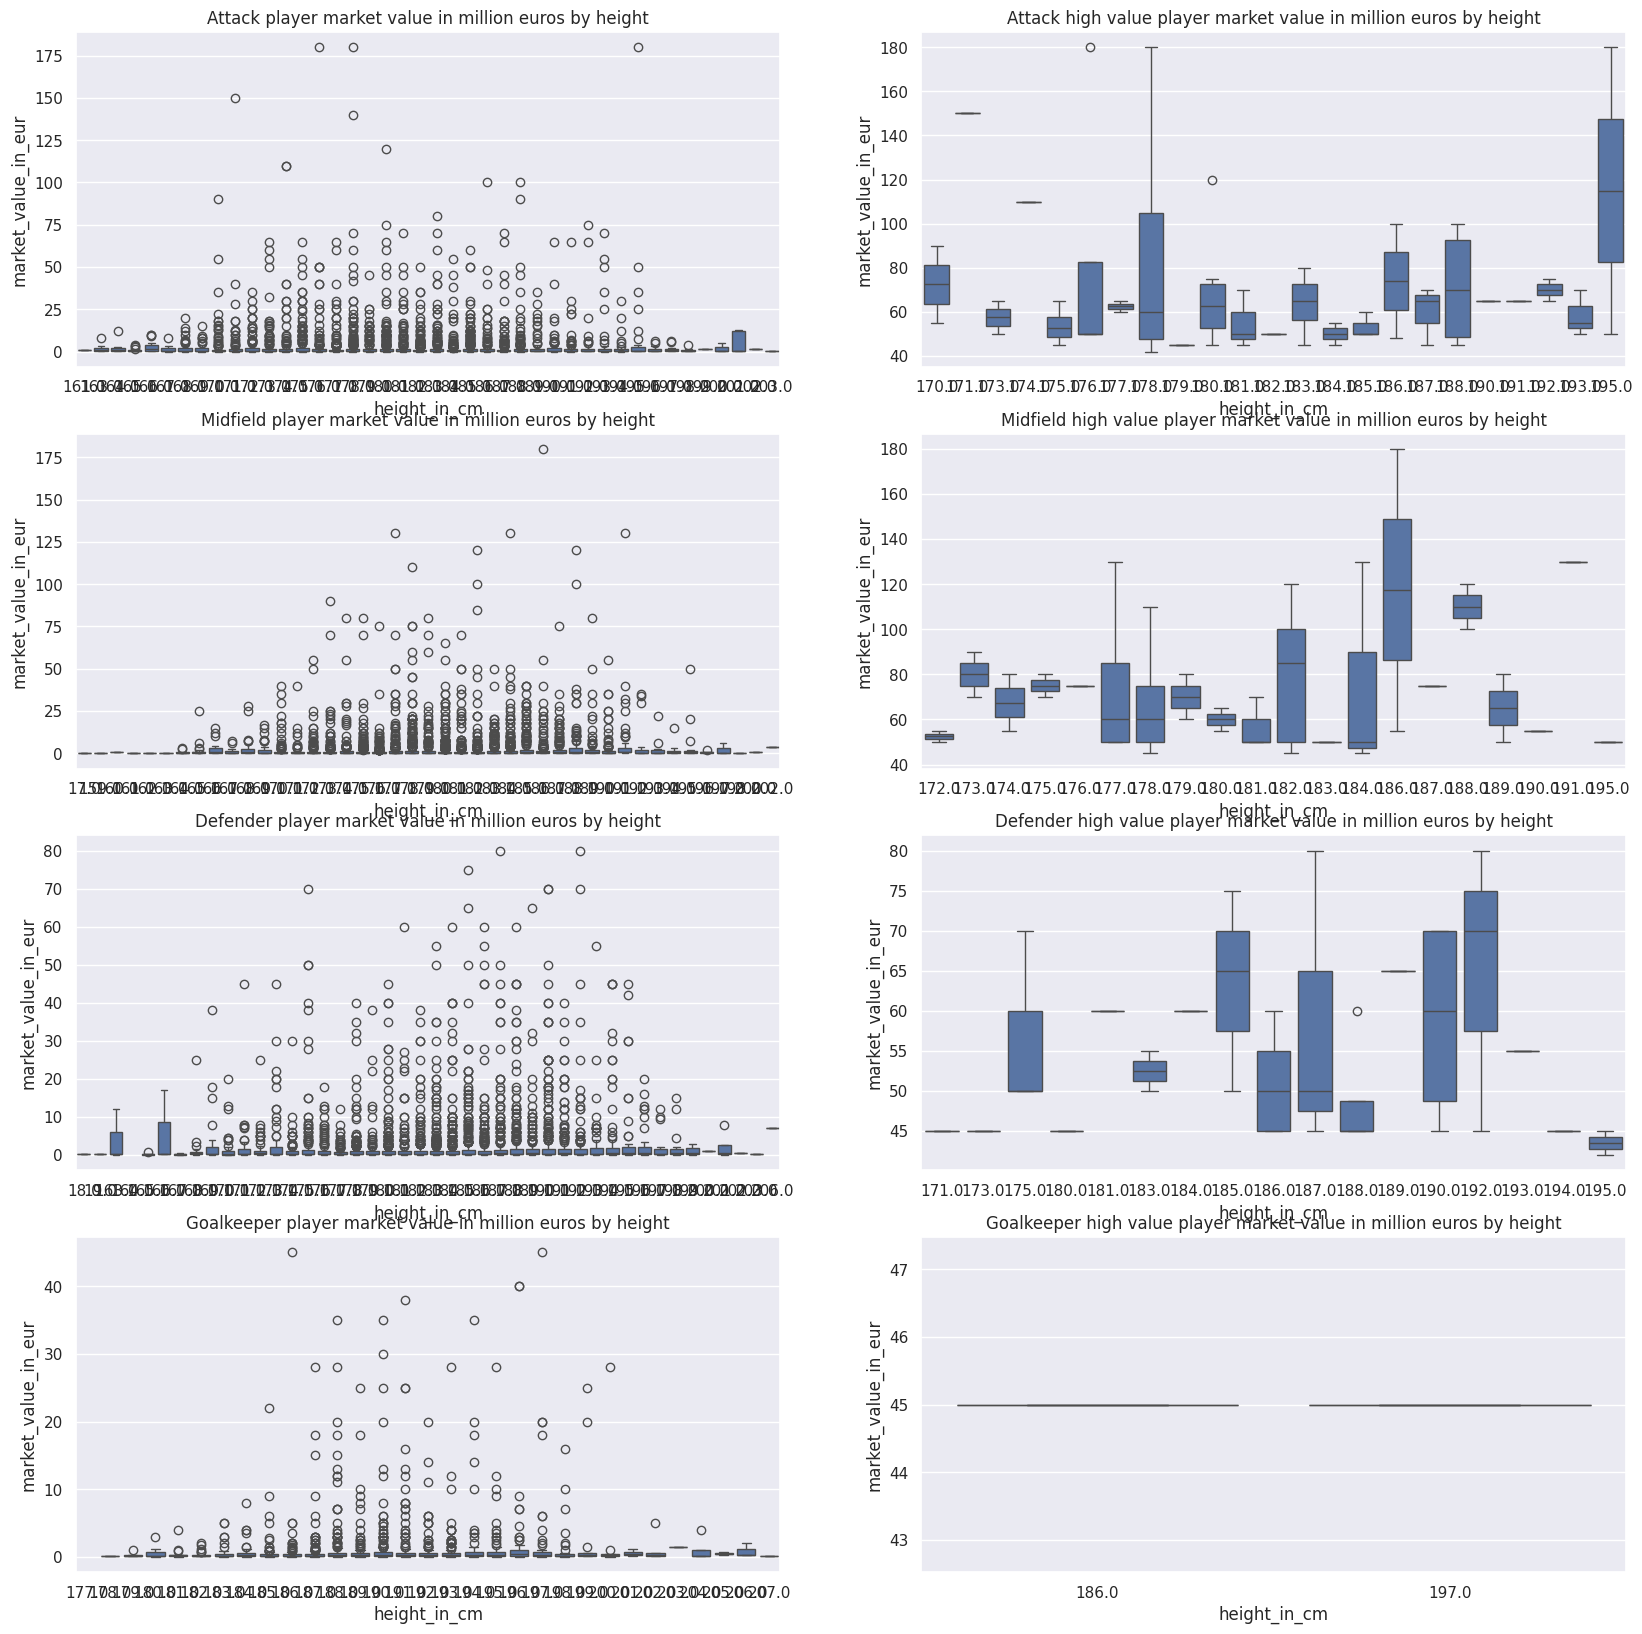

In [ ]:
# drop players with no height
players_df3 = players_df[players_df['height_in_cm'] >= 1]

#market value by height
heightgroups = players_df1.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .mean() \
    .sort_values(by='market_value_in_eur', ascending=False)
sns.set(rc={'figure.figsize':(20,10)})
plt.ylabel('Market value')
sns.boxplot(x=players_df1["height_in_cm"], y=(players_df1['market_value_in_eur'])/1000000)
plt.title('Average Market Value by height in Million Euros', fontsize=28)
plt.show()

# show Market Value for each position by height
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(421);ax2 = f.add_subplot(422);ax3 = f.add_subplot(423);ax4 = f.add_subplot(424)
ax5 = f.add_subplot(425);ax6 = f.add_subplot(426);ax7 = f.add_subplot(427);ax8 = f.add_subplot(428)

n=1
for position in positions:
    plt.subplot(4,2,n)
    n=n+1
    players_df4 = players_df3[players_df3['position'] == position]
    heightgroups = players_df4.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=players_df4["height_in_cm"], y=(players_df4['market_value_in_eur'])/1000000)
    title=str(position+' player market value in million euros by height')
    plt.title(title)
    plt.subplot(4,2,n); n=n+1
    high_value_players_df2 = high_value_players_df[high_value_players_df['position'] == position]
    heightgroups = high_value_players_df2.loc[:,['market_value_in_eur', 'height_in_cm']] \
    .groupby(['height_in_cm']) \
    .median() \
    .sort_values(by='market_value_in_eur', ascending=False)
    sns.boxplot(x=high_value_players_df2["height_in_cm"], y=(high_value_players_df2['market_value_in_eur'])/1000000)
    title=str(position+' high value player market value in million euros by height')
    plt.title(title)
plt.show()

## Observations on height

The height distribution of players is a normal distribution ranging from 160cm to 200cm with an average age of 181cm. The average height for heigh value players is about 1cm taller that the general average.

There are relatively fee high value goal keepers, but they are all tall ranging froom 188 to 200cm.

There appears to be a normal like relationship between height and market value for each position when you look at all players, but does not appear to be any significant relationship between height and market value in the most valuable players.

## Top players by Market Value

In [ ]:
high_value_players_df2=high_value_players_df1.sort_values('market_value_in_eur',ascending = False)
highest_value_players_df2=high_value_players_df1.sort_values('highest_market_value_in_eur',ascending = False)

print((high_value_players_df2[['name',"market_value_in_eur"]]).head(15));print("*****")
print(highest_value_players_df2[['name',"highest_market_value_in_eur"]].head(15));print("*****")

                    name  market_value_in_eur
25745    Jude Bellingham          180000000.0
19987    Vinicius Junior          180000000.0
18780      Kylian Mbappé          180000000.0
21632     Erling Haaland          180000000.0
21316         Phil Foden          150000000.0
22062        Bukayo Saka          140000000.0
25708      Jamal Musiala          130000000.0
26116      Florian Wirtz          130000000.0
19515              Rodri          130000000.0
19864  Federico Valverde          120000000.0
31098       Lamine Yamal          120000000.0
19520        Declan Rice          120000000.0
21463            Rodrygo          110000000.0
17627    Martin Ødegaard          110000000.0
21312   Lautaro Martínez          110000000.0
*****
                    name  highest_market_value_in_eur
18780      Kylian Mbappé                  200000000.0
19987    Vinicius Junior                  180000000.0
21632     Erling Haaland                  180000000.0
5941              Neymar                  

# Statistical Overview

In [ ]:
# print info and describe for each dataframe

for i, df in enumerate(dataframes):
    print("***********")
    print(df.info())
    print(df.describe())

***********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77847 entries, 0 to 77846
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            77847 non-null  int64  
 1   transfer_date        77847 non-null  object 
 2   transfer_season      77847 non-null  object 
 3   from_club_id         77847 non-null  int64  
 4   to_club_id           77847 non-null  int64  
 5   from_club_name       77847 non-null  object 
 6   to_club_name         77847 non-null  object 
 7   transfer_fee         50730 non-null  float64
 8   market_value_in_eur  48206 non-null  float64
 9   player_name          77847 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 5.9+ MB
None
          player_id   from_club_id     to_club_id  transfer_fee  market_value_in_eur
count  7.784700e+04   77847.000000   77847.000000  5.073000e+04         4.820600e+04
mean   4.160119e+05   16982.522936   12818

# Collating All Player Data

Having look at each the data in each of the data files, I'm going to pull all of the data together for each player, so that we can look at feature importance and start to model transfer values.

In [ ]:
# This was by attempt to collate all of the player data, but i found a far more elegant solution from LOIS CORDEIRO see below

#Start with players_df
merged_players_df=players_df.drop(['current_club_id', 'city_of_birth', 'date_of_birth','first_name', 'last_name', 'player_code', 'image_url', 'url'], axis=1)

#next look at clubs_df
merged_players_df = merged_players_df.reindex(columns = merged_players_df.columns.tolist() + ['club_value','squad_size','goals','goals_2022','games_2022','assists_2022','minutes_played_2022','goals_against_2022','goals_for_2022','clean_sheet_2022'])
for player_id in merged_players_df.player_id.unique():
    #print(players_df.current_club_id[(players_df.player_id==player_id)])
    club_id= players_df.current_club_id[(players_df.player_id==player_id)]
    #print(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    #print(clubs_df.squad_size[(clubs_df.club_id==int(club_id))])
    try:
        merged_players_df.club_value[(players_df.player_id==player_id)]=int(clubs_df.total_market_value[(clubs_df.club_id==int(club_id))])
    except:
        merged_players_df.club_value[(players_df.player_id==player_id)]='NaN'
    merged_players_df.squad_size[(players_df.player_id==player_id)]=int((clubs_df.squad_size[(clubs_df.club_id==int(club_id))]))
#sort column order
columns=['player_id','games_2022','minutes_played_2022','goals_2022','assists_2022','goals_against_2022','goals_for_2022','clean_sheet_2022','name','position','sub_position','last_season','foot','height_in_cm','age','country_of_citizenship','country_of_birth','current_club_name','club_value','squad_size','current_club_domestic_competition_id','agent_name','contract_expiration_date','term_days_remaining','market_value_in_eur','highest_market_value_in_eur']
merged_players_df=merged_players_df[columns]
#print(merged_players_df.head())

#merge games and appearances
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
print('Player and club data merged');#print(games_and_appearances_df.shape);print(games_and_appearances_df.columns);print(games_and_appearances_df.head(1))

Player and club data merged


In [ ]:
#collate stats game, appearance and goal date for each player.
#code based on code from luis gasparcordeiro's notebook at https://www.kaggle.com/code/luisgasparcordeiro/market-value-eda/notebook

#merge games and appearances
games_and_appearances_df = appearances_df.merge(games_df, on=['game_id'], how='left')
season = 2022

#create a function to collate player stats
def player_stats(player_id, season, df):
    df = games_and_appearances_df[games_and_appearances_df['player_id'] == player_id]
    df =  df[ df['season'] == season]
    if (df.shape[0] == 0):
        Out = [(np.nan, season,0,0,0,0,0,0,0,0,0)]
        out_df = pd.DataFrame(data = Out, columns = ['player_id','season','goals','games',
                                                     'assists','minutes_played','goals_for','goals_against','clean_sheet','yellow_cards','red_cards'])
        return out_df
    else:
        df["goals_for"] = df.apply(lambda row: row['home_club_goals'] if row['home_club_id'] == row['player_club_id']
            else row['away_club_goals'] if row['away_club_id'] == row['player_club_id']
            else np.nan, axis=1)
        df["goals_against"] = df.apply(lambda row: row['away_club_goals'] if row['home_club_id'] == row['player_club_id']
            else row['home_club_goals'] if row['away_club_id'] == row['player_club_id']
            else np.nan, axis=1)
        df['clean_sheet'] = df.apply(lambda row: 1 if row['goals_against'] == 0
            else 0 if row['goals_against'] > 0
            else np.nan, axis=1)
        df = df.groupby(['player_id',"season"],as_index=False).agg({'goals': 'sum', 'game_id': 'nunique',
                                                                      'assists': 'sum', 'minutes_played' : 'sum', 'goals_for' : 'sum',
                                                                      'goals_against' : 'sum', 'clean_sheet' : 'sum','yellow_cards':'sum','red_cards':'sum'})
        out_df = df.rename(columns={'game_id': 'games'})
        return out_df
#print(player_stats(67064, 2014, games_and_appearances_df)) #test function works.

#iterate through players
for index in merged_players_df.index:
    id = merged_players_df.loc[index][0]
    #print(id)
    name = merged_players_df.loc[index][1]
    stats = player_stats(id, season, games_and_appearances_df)
    try:
        merged_players_df.at[index,'games_{}'.format(season)]= stats['games'][0]
        merged_players_df.at[index,'goals_{}'.format(season)]= stats['goals'][0]
        merged_players_df.at[index,'assists_{}'.format(season)]= stats['assists'][0]
        merged_players_df.at[index,'minutes_played_{}'.format(season)]= stats['minutes_played'][0]
        merged_players_df.at[index,'goals_for_{}'.format(season)]= stats['goals_for'][0]
        merged_players_df.at[index,'goals_against_{}'.format(season)]= stats['goals_against'][0]
        merged_players_df.at[index,'clean_sheet_{}'.format(season)]= stats['clean_sheet'][0]
        merged_players_df.at[index,'yellow_cards_{}'.format(season)]= stats['yellow_cards'][0]
        merged_players_df.at[index,'red_cards_{}'.format(season)]= stats['red_cards'][0]
    except:
        #print(id)
        n=n+1
print('appearance,goal and card data merged')
print(merged_players_df.info());#print(merged_players_df.describe())

appearance,goal and card data merged
<class 'pandas.core.frame.DataFrame'>
Index: 20263 entries, 9 to 32408
Data columns (total 28 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   player_id                             20263 non-null  int64         
 1   games_2022                            20263 non-null  float64       
 2   minutes_played_2022                   20263 non-null  float64       
 3   goals_2022                            20263 non-null  float64       
 4   assists_2022                          20263 non-null  float64       
 5   goals_against_2022                    20263 non-null  float64       
 6   goals_for_2022                        20263 non-null  float64       
 7   clean_sheet_2022                      20263 non-null  float64       
 8   name                                  20263 non-null  object        
 9   position                              20

# Pairplots

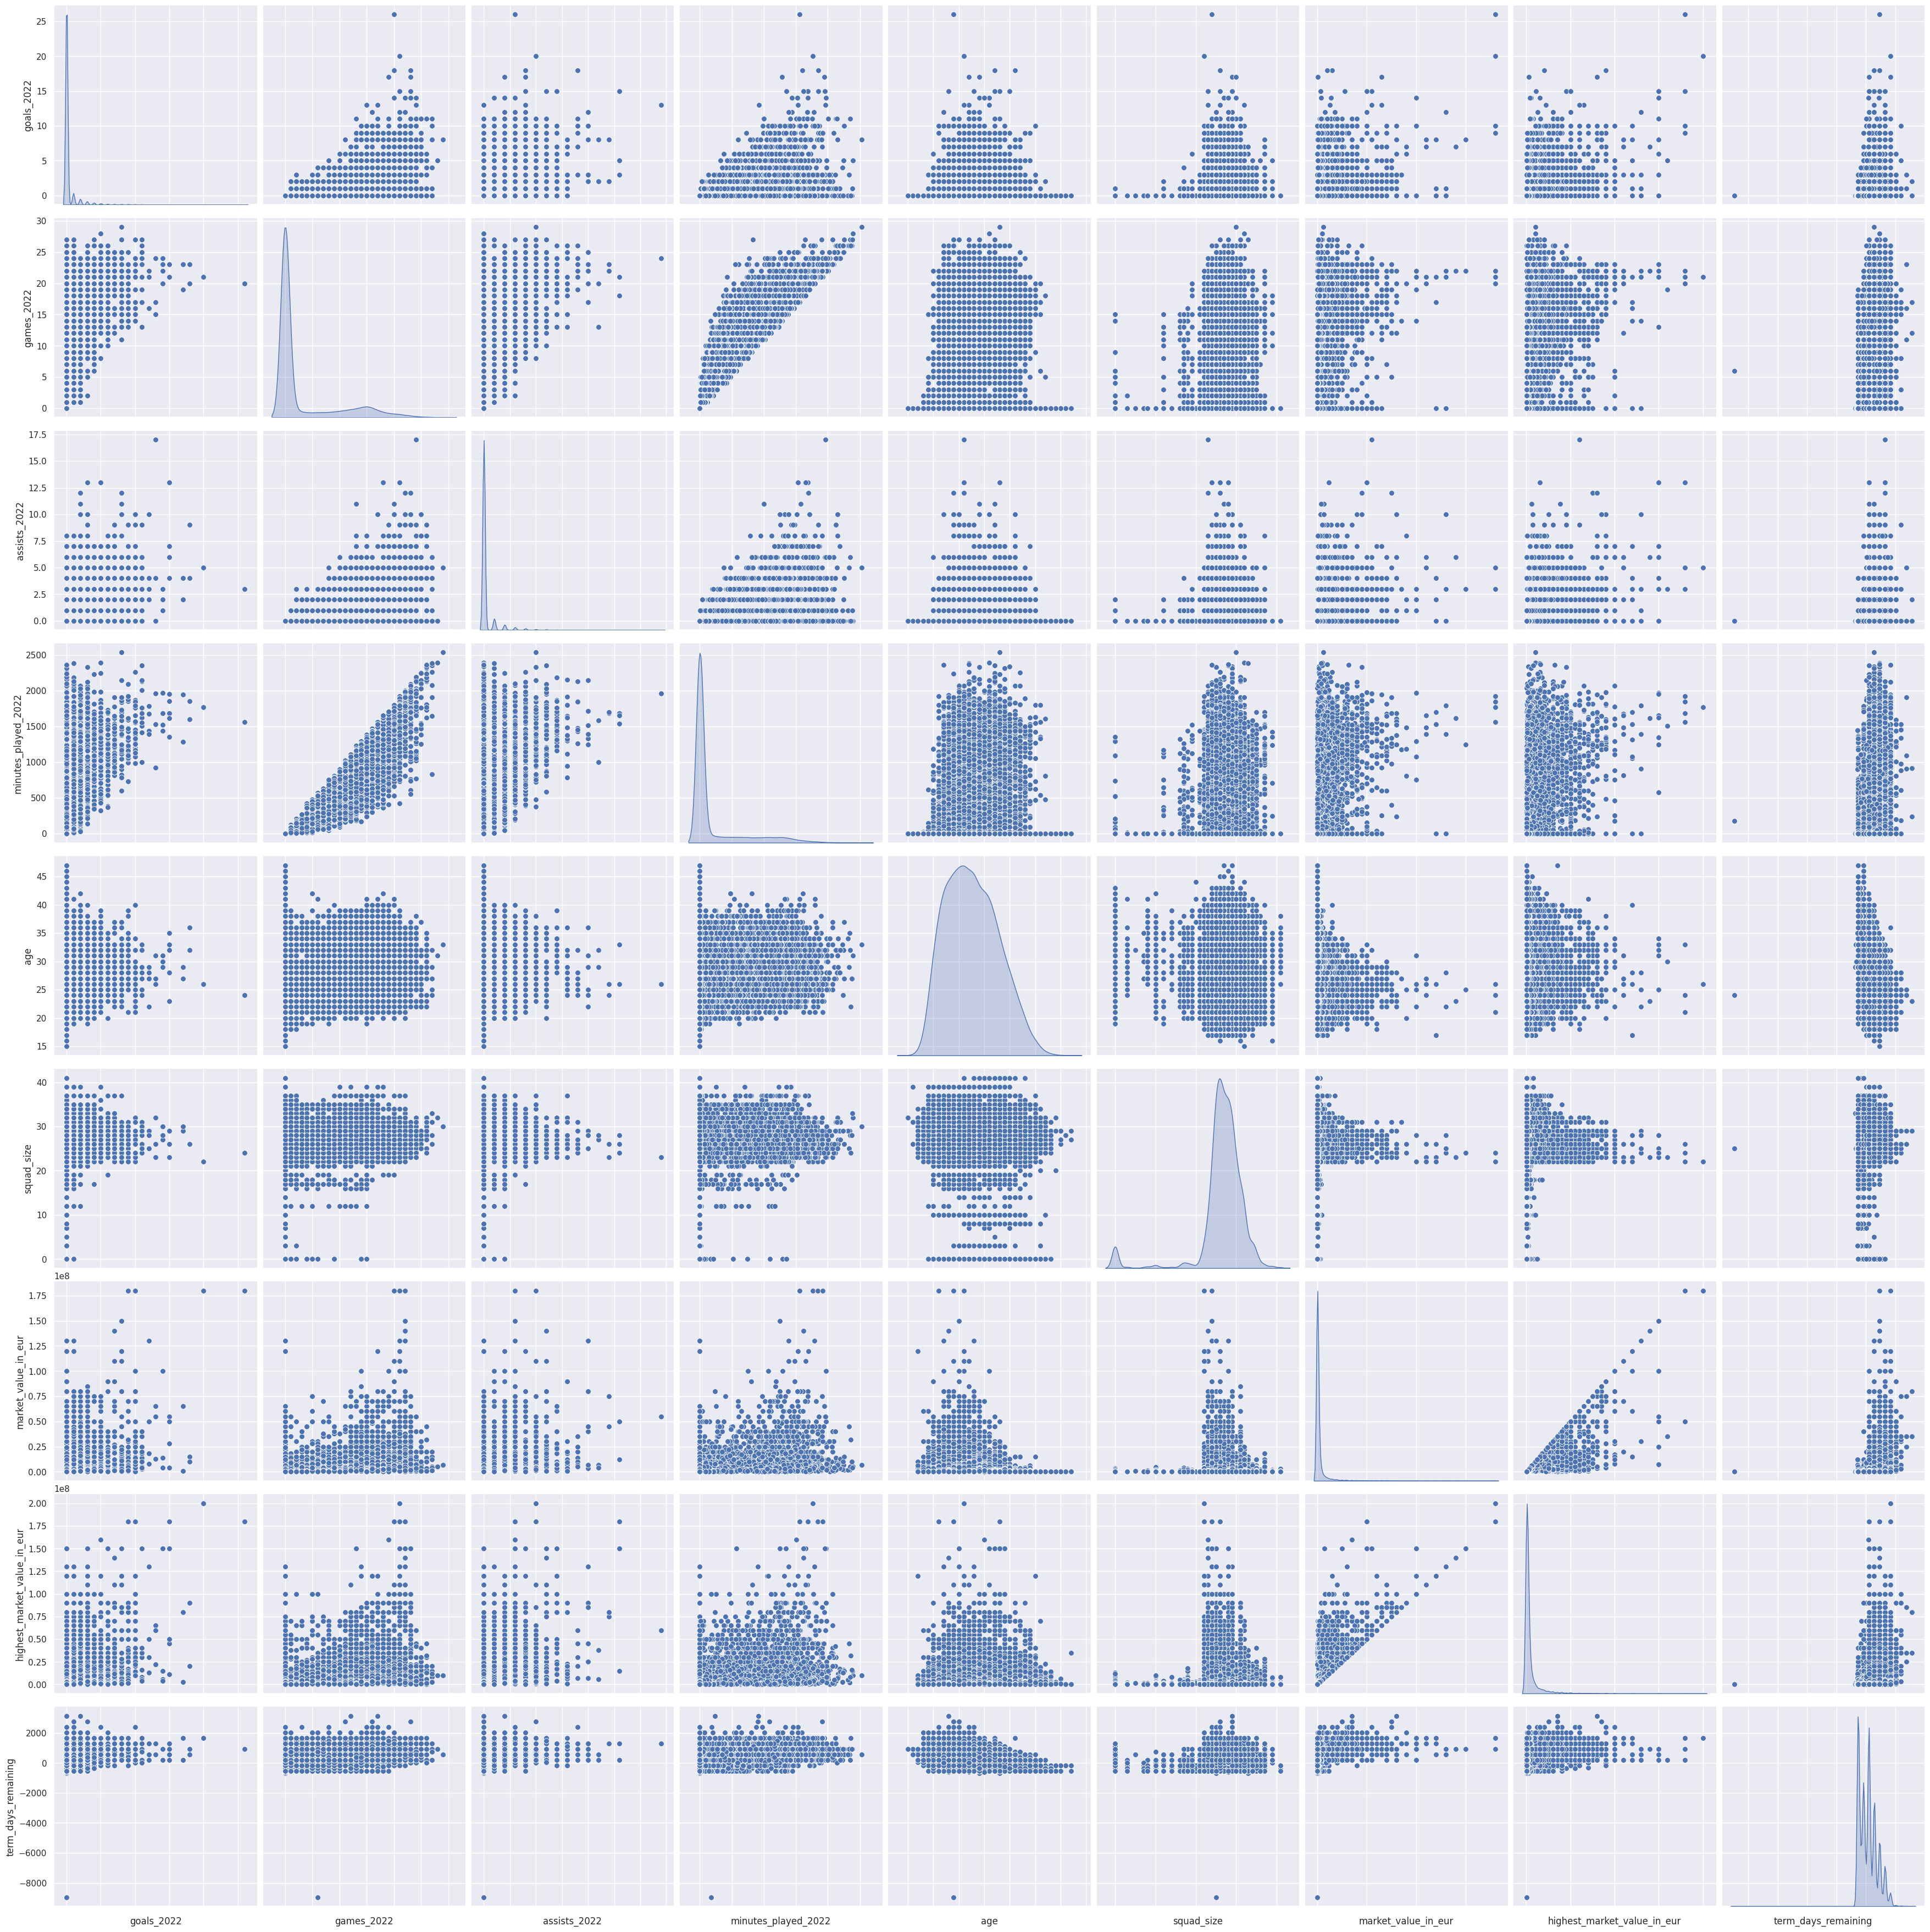

In [ ]:
g = sns.pairplot(merged_players_df[[u'goals_2022', u'games_2022', u'assists_2022', u'minutes_played_2022',u'age',u'squad_size',u'market_value_in_eur',u'highest_market_value_in_eur',u'term_days_remaining']], palette = 'seismic',size=4,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

# Pearson Correlation of Features

Index(['games_2022', 'minutes_played_2022', 'goals_2022', 'assists_2022', 'goals_against_2022', 'goals_for_2022', 'clean_sheet_2022', 'age', 'club_value', 'squad_size', 'term_days_remaining', 'market_value_in_eur', 'highest_market_value_in_eur', 'yellow_cards_2022', 'red_cards_2022'], dtype='object')


<Axes: title={'center': 'Pearson Correlation of Features'}>

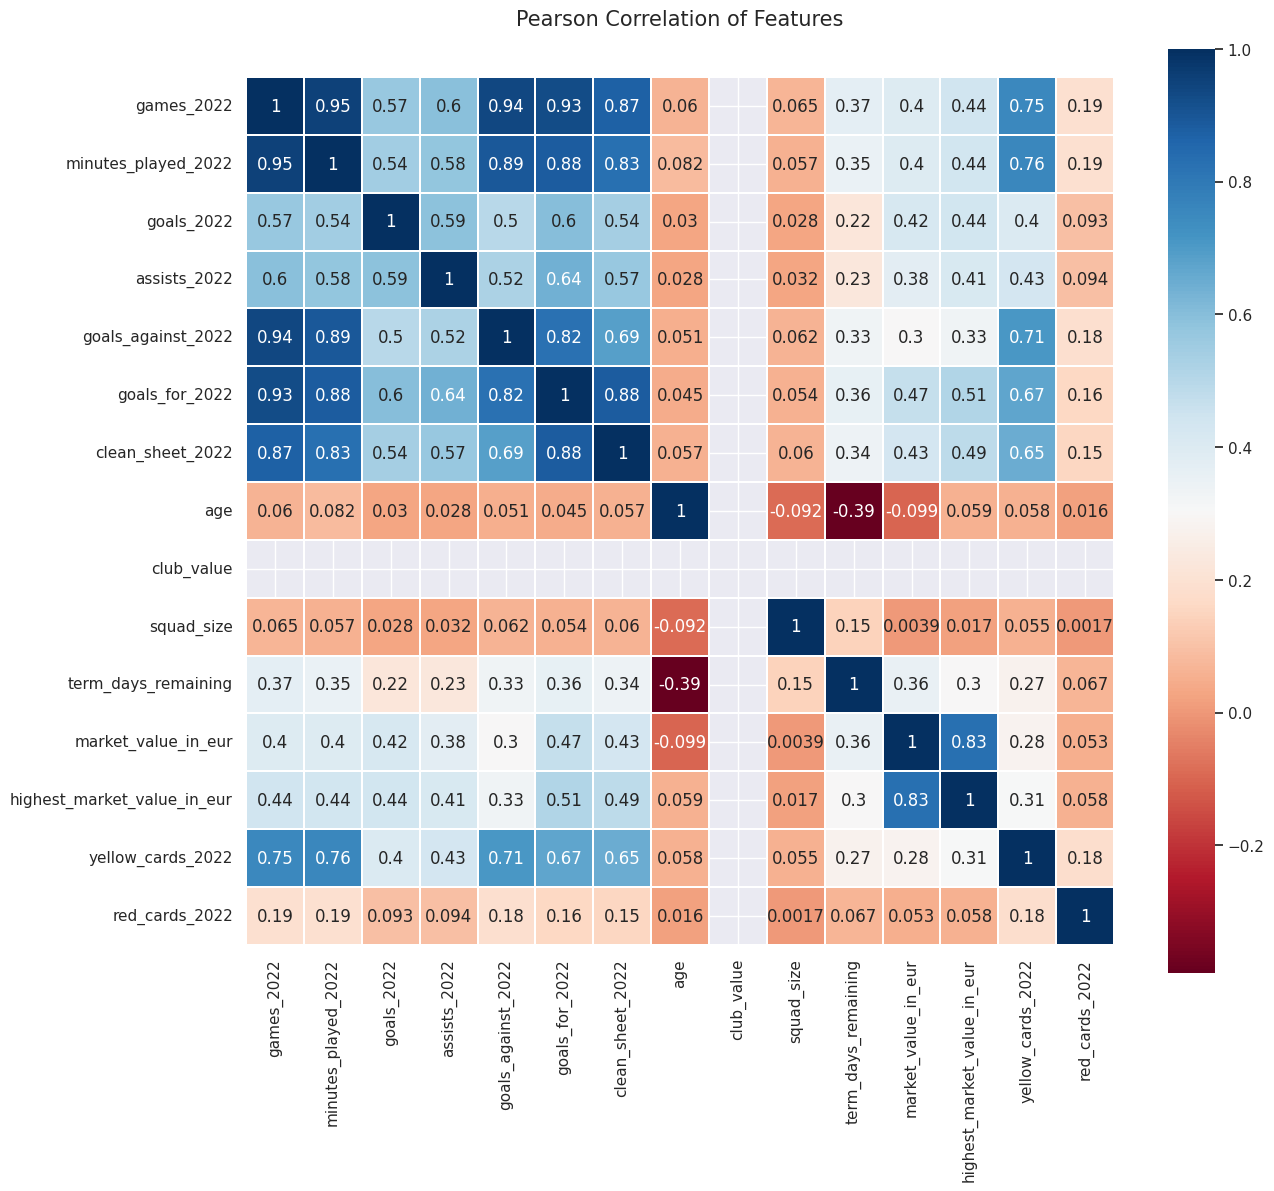

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
features_df=merged_players_df.drop(['player_id','name','position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date'],axis=1)
print(features_df.columns)
sns.heatmap(features_df.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True)

# Generate First Model

For the first model we have used 8 columns of Numberical data only with a basic decision tree regressor.

In [ ]:
#separate numeric columns
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size']
OTHER_COLUMNS=['position','sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
#drop nan
merged_players_df=merged_players_df.dropna(subset=['market_value_in_eur'])
# create test and training data
X = merged_players_df[NUMERIC_COLUMNS].fillna(-1000)
y=merged_players_df['market_value_in_eur']
#split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
#model data
clf = SVR(kernel="linear")
clf.fit(X_train, y_train)
#assess accurancy of model
print("Accuracy: {}".format(clf.score(X_test, y_test)))
#generate predictions
test = X_test[NUMERIC_COLUMNS].fillna(-1000)
Submission=clf.predict(test)
#print(Submission.head(5))

Accuracy: 0.046707599763881835


# Observation on first model

The results from this model based on only numerical data are 0.079, which is not surprisingly very poor because we are comparing goals scored in minor leagues with goals scored in premier leauges, we are also comparing results for strikers with results for goal keepers. We therefore need to do some feature feature enhgineering to make use of the categorical data.

# Initial Feature Engineering

In [ ]:
#filter out only Gb players
merged_players_df1 = merged_players_df[(merged_players_df.current_club_domestic_competition_id=='GB1')]
# convert position categories to Columns for test data
dummies=pd.get_dummies(merged_players_df1[['position']], prefix_sep='_') #position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1)
print('initial feature engineering complete') #print(merged_players_df1.head())

initial feature engineering complete


# Re-evaluate model

In [ ]:
NUMERIC_COLUMNS=['goals_2022','goals_against_2022', 'goals_for_2022','games_2022','assists_2022','minutes_played_2022','age','squad_size','term_days_remaining','position_Attack','position_Defender','position_Goalkeeper','position_Midfield']
OTHER_COLUMNS=['sub_position','last_season','foot','height_in_cm','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
# create test and training data
y=merged_players_df1['market_value_in_eur']
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)
#split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21)
#model data
clf = GradientBoostingRegressor(random_state=0)
#clf = SVR(kernel="linear",gamma="auto")
#clf = DecisionTreeRegressor(random_state=0)
clf.fit(X_train, y_train)
#assess accurancy of model
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.6817081859731139


# Observation on revised model

By simply filtering out the domestic competition to GB1 only and converting to position data to categorical data we managed to get the accuracy up to 0.508.

While this model is still wily inaccurate, its a good indication that by taking more of the categorical data into account and optimising the model used that we might be able to generate a model that could estimate market value for players.

# Further feature engineering

In [ ]:
# convert position categories to Columns for test data
dummies=pd.get_dummies(merged_players_df1[['sub_position']], prefix_sep='_') #sub position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1)
dummies=pd.get_dummies(merged_players_df1[['foot']], prefix_sep='_') #foot
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1)
#print(merged_players_df1[NUMERIC_COLUMNS].head())

In [ ]:
merged_players_df1.head()

player_id  games_2022  minutes_played_2022  goals_2022  assists_2022  goals_against_2022  goals_for_2022  clean_sheet_2022               name    position      sub_position  last_season   foot  height_in_cm  age country_of_citizenship   country_of_birth                       current_club_name club_value  squad_size current_club_domestic_competition_id         agent_name contract_expiration_date  term_days_remaining  market_value_in_eur  highest_market_value_in_eur  yellow_cards_2022  red_cards_2022  position_Attack  position_Defender  position_Goalkeeper  position_Midfield  position_Missing  sub_position_Attacking Midfield  sub_position_Central Midfield  sub_position_Centre-Back  sub_position_Centre-Forward  sub_position_Defensive Midfield  sub_position_Goalkeeper  sub_position_Left Midfield  sub_position_Left Winger  sub_position_Left-Back  sub_position_Right Midfield  sub_position_Right Winger  sub_position_Right-Back  sub_position_Second Striker  foot_both  foot_left  foot_right
122       2857         0.0                  0.0         0.0           0.0                 0.0             0.0               0.0    Eldin Jakupovic  Goalkeeper        Goalkeeper         2022  right         191.0   40            Switzerland  Jugoslawien (SFR)                   Everton Football Club        NaN        25.0                                  GB1                NaN               2023-12-31                 -339             100000.0                    1500000.0                0.0             0.0            False              False                 True              False             False                            False                          False                     False                        False                            False                     True                       False                     False                   False                        False                      False                    False                        False      False      False        True
188       3333        19.0                630.0         0.0           1.0                20.0            44.0               7.0       James Milner    Midfield  Central Midfield         2024  right         175.0   39                England            England  Brighton and Hove Albion Football Club        NaN        28.0                                  GB1                NaN               2025-06-30                  208            1000000.0                   21000000.0                1.0             0.0            False              False                False               True             False                            False                           True                     False                        False                            False                    False                       False                     False                   False                        False                      False                    False                        False      False      False        True
251       3755         0.0                  0.0         0.0           0.0                 0.0             0.0               0.0       Óscar Ustari  Goalkeeper        Goalkeeper         2013  right         183.0   38              Argentina          Argentina                          Sunderland AFC        NaN        26.0                                  GB1         Primotempo               2023-12-31                 -339             600000.0                    7000000.0                0.0             0.0            False              False                 True              False             False                            False                          False                     False                        False                            False                     True                       False                     False                   False                        False                      False                    False                        False      False      False        True
6

In [ ]:
NUMERIC_COLUMNS

['goals_2022',
 'goals_against_2022',
 'goals_for_2022',
 'games_2022',
 'assists_2022',
 'minutes_played_2022',
 'age',
 'height_in_cm',
 'squad_size',
 'term_days_remaining',
 'position_Attack',
 'position_Defender',
 'position_Goalkeeper',
 'position_Midfield',
 'sub_position_Attacking Midfield',
 'sub_position_Central Midfield',
 'sub_position_Centre-Back',
 'sub_position_Centre-Forward',
 'sub_position_Defensive Midfield',
 'sub_position_Left Midfield',
 'sub_position_Left Winger',
 'sub_position_Left-Back',
 'sub_position_Right Midfield',
 'sub_position_Right Winger',
 'sub_position_Right-Back',
 'sub_position_Second Striker',
 'foot_left',
 'foot_right',
 'foot_both']

# Further model evaluation

In [ ]:
# convert position categories to Columns for test data
dummies=pd.get_dummies(merged_players_df1[['sub_position']], prefix_sep='_') #sub position
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1)
dummies=pd.get_dummies(merged_players_df1[['foot']], prefix_sep='_') #foot
merged_players_df1 = pd.concat([merged_players_df1, dummies], axis=1)
# Define columns
NUMERIC_COLUMNS = [
    'goals_2022', 'goals_against_2022', 'goals_for_2022', 'games_2022',
    'assists_2022', 'minutes_played_2022', 'age', 'height_in_cm',
    'squad_size', 'term_days_remaining', 'position_Attack',
    'position_Defender', 'position_Goalkeeper', 'position_Midfield',
    'sub_position_Attacking Midfield', 'sub_position_Central Midfield',
    'sub_position_Centre-Back', 'sub_position_Centre-Forward',
    'sub_position_Defensive Midfield', 'sub_position_Left Midfield',
    'sub_position_Left Winger', 'sub_position_Left-Back',
    'sub_position_Right Midfield', 'sub_position_Right Winger',
    'sub_position_Right-Back', 'sub_position_Second Striker',
    'foot_left', 'foot_right', 'foot_both'
]
OTHER_COLUMNS=['last_season','country_of_citizenship','country_of_birth','current_club_name','current_club_domestic_competition_id','agent_name','contract_expiration_date']
# Define target column
TARGET_COLUMN = 'market_value_in_eur'

# Load and prepare data
X = merged_players_df1[NUMERIC_COLUMNS].fillna(-1000)  # Replace NaNs with -1000
y = merged_players_df1[TARGET_COLUMN]

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

# Initialize the GradientBoostingRegressor model
gbr = GradientBoostingRegressor(random_state=0)

# Train the model
gbr.fit(X_train, y_train)

# Evaluate accuracy
accuracy = gbr.score(X_test, y_test)
print(f"GradientBoostingRegressor Accuracy: {accuracy:.2f}")

# Make predictions
merged_players_df1['predicted_market_value'] = gbr.predict(X)

# Save the updated DataFrame back to a file
output_file = 'updated_players_data.csv'
merged_players_df1.to_csv(output_file, index=False)
print(f"Updated file with predictions saved as {output_file}.")


GradientBoostingRegressor Accuracy: 0.68
Updated file with predictions saved as updated_players_data.csv.


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 961 entries, 17486 to 24362
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   goals_2022                       961 non-null    float64
 1   goals_against_2022               961 non-null    float64
 2   goals_for_2022                   961 non-null    float64
 3   games_2022                       961 non-null    float64
 4   assists_2022                     961 non-null    float64
 5   minutes_played_2022              961 non-null    float64
 6   age                              961 non-null    int64  
 7   height_in_cm                     961 non-null    float64
 8   squad_size                       961 non-null    float64
 9   term_days_remaining              961 non-null    int64  
 10  position_Attack                  961 non-null    bool   
 11  position_Defender                961 non-null    bool   
 12  position_Goalkeeper  

In [ ]:
merged_players_df1.head()

player_id  games_2022  minutes_played_2022  goals_2022  assists_2022  goals_against_2022  goals_for_2022  clean_sheet_2022               name    position      sub_position  last_season   foot  height_in_cm  age country_of_citizenship   country_of_birth                       current_club_name club_value  squad_size current_club_domestic_competition_id         agent_name contract_expiration_date  term_days_remaining  market_value_in_eur  highest_market_value_in_eur  yellow_cards_2022  red_cards_2022  position_Attack  position_Defender  position_Goalkeeper  position_Midfield  position_Missing  sub_position_Attacking Midfield  sub_position_Central Midfield  sub_position_Centre-Back  sub_position_Centre-Forward  sub_position_Defensive Midfield  sub_position_Goalkeeper  sub_position_Left Midfield  sub_position_Left Winger  sub_position_Left-Back  sub_position_Right Midfield  sub_position_Right Winger  sub_position_Right-Back  sub_position_Second Striker  foot_both  foot_left  foot_right  sub_position_Attacking Midfield  sub_position_Central Midfield  sub_position_Centre-Back  sub_position_Centre-Forward  sub_position_Defensive Midfield  sub_position_Goalkeeper  \
122       2857         0.0                  0.0         0.0           0.0                 0.0             0.0               0.0    Eldin Jakupovic  Goalkeeper        Goalkeeper         2022  right         191.0   40            Switzerland  Jugoslawien (SFR)                   Everton Football Club        NaN        25.0                                  GB1                NaN               2023-12-31                 -339             100000.0                    1500000.0                0.0             0.0            False              False                 True              False             False                            False                          False                     False                        False                            False                     True                       False                     False                   False                        False                      False                    False                        False      False      False        True                            False                          False                     False                        False                            False                     True   
188       3333        19.0                630.0         0.0           1.0                20.0            44.0               7.0       James Milner    Midfield  Central Midfield         2024  right         175.0   39                England            England  Brighton and Hove Albion Football Club        NaN        28.0                                  GB1                NaN               2025-06-30                  208            1000000.0                   21000000.0                1.0             0.0            False              False                False               True             False                            False                           True                     False                        False                            False                    False                       False                     False                   False                        False                      False                    False                        False      False      False        True                            False                           True                     False                        False                            False                    False   
251       3755         0.0                  0.0         0.0           0.0                 0.0             0.0               0.0       Óscar Ustari  Goalkeeper        Goalkeeper         2013  right         183.0   38              Argentina          Argentina                          Sunderland AFC        NaN        26.0                                  GB1         Primotempo               2023-12-31                 -339             600000.0                   

Comparison data saved as comparison_actual_vs_predicted.csv.


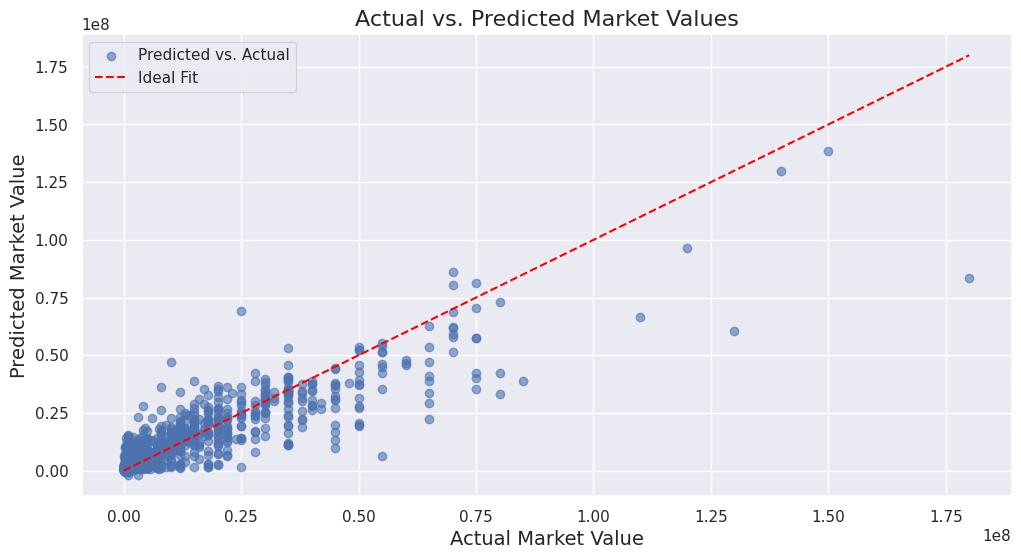

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame for comparison
comparison_df = merged_players_df1[['market_value_in_eur', 'predicted_market_value']]

# Calculate the difference (optional, for analysis)
comparison_df['difference'] = comparison_df['market_value_in_eur'] - comparison_df['predicted_market_value']

# Save the comparison DataFrame (optional)
comparison_file = 'comparison_actual_vs_predicted.csv'
comparison_df.to_csv(comparison_file, index=False)
print(f"Comparison data saved as {comparison_file}.")

# Visualize the comparison
plt.figure(figsize=(12, 6))
plt.scatter(
    comparison_df['market_value_in_eur'],
    comparison_df['predicted_market_value'],
    alpha=0.6, label='Predicted vs. Actual'
)
plt.plot(
    [comparison_df['market_value_in_eur'].min(), comparison_df['market_value_in_eur'].max()],
    [comparison_df['market_value_in_eur'].min(), comparison_df['market_value_in_eur'].max()],
    color='red', linestyle='--', label='Ideal Fit'
)
plt.title('Actual vs. Predicted Market Values', fontsize=16)
plt.xlabel('Actual Market Value', fontsize=14)
plt.ylabel('Predicted Market Value', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: how can I save the model "gbr" in pickle format

import pickle

# Save the model to a file
filename = 'gbr_model.pkl'
pickle.dump(gbr, open(filename, 'wb'))

print(f"Model saved as {filename}")

# Download the saved model file (optional)
# files.download(filename)

Model saved as gbr_model.pkl


In [ ]:
# prompt: can you give me the 44 features that the GBR model is taking in as features? I need all 44

NUMERIC_COLUMNS = [
    'goals_2022', 'goals_against_2022', 'goals_for_2022', 'games_2022',
    'assists_2022', 'minutes_played_2022', 'age', 'height_in_cm',
    'squad_size', 'term_days_remaining', 'position_Attack',
    'position_Defender', 'position_Goalkeeper', 'position_Midfield',
    'sub_position_Attacking Midfield', 'sub_position_Central Midfield',
    'sub_position_Centre-Back', 'sub_position_Centre-Forward',
    'sub_position_Defensive Midfield', 'sub_position_Left Midfield',
    'sub_position_Left Winger', 'sub_position_Left-Back',
    'sub_position_Right Midfield', 'sub_position_Right Winger',
    'sub_position_Right-Back', 'sub_position_Second Striker',
    'foot_left', 'foot_right', 'foot_both'
]
print(len(NUMERIC_COLUMNS)) # verify the number of features
NUMERIC_COLUMNS

29


['goals_2022',
 'goals_against_2022',
 'goals_for_2022',
 'games_2022',
 'assists_2022',
 'minutes_played_2022',
 'age',
 'height_in_cm',
 'squad_size',
 'term_days_remaining',
 'position_Attack',
 'position_Defender',
 'position_Goalkeeper',
 'position_Midfield',
 'sub_position_Attacking Midfield',
 'sub_position_Central Midfield',
 'sub_position_Centre-Back',
 'sub_position_Centre-Forward',
 'sub_position_Defensive Midfield',
 'sub_position_Left Midfield',
 'sub_position_Left Winger',
 'sub_position_Left-Back',
 'sub_position_Right Midfield',
 'sub_position_Right Winger',
 'sub_position_Right-Back',
 'sub_position_Second Striker',
 'foot_left',
 'foot_right',
 'foot_both']